# Chapter 2: Assessing People's Skills
https://mbmlbook.com/LearningSkills.html

In [1]:
import warnings
import sys

import arviz as az
import pandas as pd
import numpy as np

import pymc3 as pm
import theano.tensor as tt

import matplotlib.pyplot as plt
import seaborn as sns

%config Completer.use_jedi = False 

In [2]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

print(f"Python version: {sys.version}")
print(f"Running on PyMC3 v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Python version: 3.9.10 | packaged by conda-forge | (main, Feb  1 2022, 21:27:48) 
[Clang 11.1.0 ]
Running on PyMC3 v3.11.4
Running on ArviZ v0.11.4


## 2.0 [Set-up](https://mbmlbook.com/LearningSkills.html)
    
    
    Multiple choice questions (5 possible answers)
    Questions vary, depending on what set of skills are required to answer it correctly:
        * only c#
        * only sql
        * both c# and sql
        

## 2.1 [Model is a set of assumptions](https://mbmlbook.com/LearningSkills_A_model_is_a_set_of_assumptions.html)
    1. A candidate has either mastered each skill or not.

    2. Before seeing any test results, it is equally likely that a candidate does or doesn’t have any particular skill => prior probability of any skill is 50%.
    
    3. If a candidate has all of the skills needed for a question then they will usually get the question right, except one time in ten they will make a mistake => introduce noise into the model (probability of being wrong given that s/he mastered the skill).
    
    4. If a candidate doesn’t have all the skills needed for a question, they will pick an answer at random. Because this is a multiple-choice exam with five answers, there’s a one in five chance that they get the question right.

In [3]:
PRIOR_SKILL = 0.5

PROB_RIGHT_GIVEN_SKILL = 0.9
PROB_WRONG_GIVEN_SKILL = 1 - PROB_RIGHT_GIVEN_SKILL

PROB_RIGHT_GIVEN_NO_SKILL= 0.2
PROB_WRONG_GIVEN_NO_SKILL = 1 - PROB_RIGHT_GIVEN_NO_SKILL

## 2.2. [Testing the model](https://mbmlbook.com/LearningSkills_Testing_out_the_model.html)

toy example with 3 questions

In [4]:
REQUIRED_SKILLS = np.array([[1, 0], # c#
                            [0, 1], # sql
                            [1, 1]] # both c# and sql
                          ) 

OBSERVED_RESULTS = np.array([1, 1, 1]) # 1 is correct, 0 - wrong

### Initialise the model

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


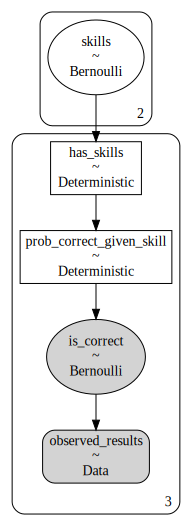

In [5]:
with pm.Model() as model:
    
    observed_results = pm.Data('observed_results', OBSERVED_RESULTS)
    skills = pm.Bernoulli('skills', p=PRIOR_SKILL * np.ones(REQUIRED_SKILLS.shape[1]), shape=REQUIRED_SKILLS.shape[1])
    required_skills = pm.math.constant(REQUIRED_SKILLS, name='required_skills')

    has_skills = pm.Deterministic('has_skills', pm.math.eq(pm.math.dot(required_skills, skills), required_skills.sum(axis=1)))
    prob_correct_given_skill = pm.Deterministic('prob_correct_given_skill', pm.math.switch(has_skills,
                                                                                           PROB_RIGHT_GIVEN_SKILL,
                                                                                           PROB_RIGHT_GIVEN_NO_SKILL))
        
    is_correct = pm.Bernoulli('is_correct', prob_correct_given_skill, observed=observed_results, shape=REQUIRED_SKILLS.shape[1])


    trace = pm.sample(1000, return_inferencedata=True)
pm.model_to_graphviz(model)

In [6]:
trace['posterior']['skills'].mean(axis=1)

<xarray.DataArray 'skills' (chain: 4, skills_dim_0: 2)>
array([[0.966, 0.942],
       [0.958, 0.937],
       [0.941, 0.935],
       [0.95 , 0.947]])
Coordinates:
  * chain         (chain) int64 0 1 2 3
  * skills_dim_0  (skills_dim_0) int64 0 1

### Run inference for all possible combinations of C#, sql, C#-sql answers

In [7]:
# Generate one trace for each possible answer combination
from itertools import product

traces = {}
for observed_result in product((0, 1), repeat=3):
    with model:
        # Switch out the observed dataset
        pm.set_data({'observed_results': np.array(observed_result)})
        traces[observed_result] = pm.sample(return_inferencedata=True)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.
Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


In [8]:
results = []
for obs_result, trace in traces.items():
    posterior_has_skills = trace.posterior.skills.mean(axis=1).mean(axis=0).round(3).to_numpy()
    results.append((str(obs_result), posterior_has_skills))
results = pd.DataFrame.from_records(results).rename(columns={0: 'answer_is_correct', 1: 'prob_c#_sql'})
results

,answer_is_correct,prob_c#_sql
0,"(0, 0, 0)","[0.095, 0.102]"
1,"(0, 0, 1)","[0.155, 0.147]"
2,"(0, 1, 0)","[0.04, 0.801]"
3,"(0, 1, 1)","[0.318, 0.869]"
4,"(1, 0, 0)","[0.808, 0.034]"
5,"(1, 0, 1)","[0.864, 0.328]"
6,"(1, 1, 0)","[0.56, 0.563]"
7,"(1, 1, 1)","[0.95, 0.948]"


### The probabilities inferred with PyMC are very close to the exact solution [here](https://mbmlbook.com/LearningSkills_Testing_out_the_model.html)

### Further reading

* [General API quickstart](https://docs.pymc.io/en/v3/pymc-examples/examples/pymc3_howto/api_quickstart.html)
* [Using shared variables (Data container adaptation)](https://docs.pymc.io/projects/examples/en/latest/pymc3_howto/data_container.html#data_container)
    * https://arviz-devs.github.io/arviz/getting_started/XarrayforArviZ.html#xarray-for-arviz
* [Math module](https://docs.pymc.io/en/v3/api/math.html)

## 4. [Moving to real data](https://mbmlbook.com/LearningSkills_Moving_to_real_data.html)

In [9]:
URL_RAW_RESPONSES = "https://mbmlbook.com/Downloads/LearningSkills_6LearningTheGuessProbabilitiesComparison_Experiments-Original-Inputs-RawResponsesAsDictionary.csv"
URL_REQUIRED_SKILLS = "https://mbmlbook.com/Downloads/LearningSkills_6LearningTheGuessProbabilitiesComparison_Experiments-Original-Inputs-Quiz-SkillsQuestionsMask.csv"

In [10]:
df = pd.read_csv(URL_RAW_RESPONSES)
df.set_index('#', inplace=True)
df.head()

,S1,S2,S3,S4,S5,S6,S7,Q1,Q2,Q3,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
#,,,,,,,,,,,,,,,,,,,,,
ANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P1,True,True,True,True,False,True,True,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P2,True,True,True,True,False,False,True,1,4,3,...,5,1,1,4,3,3,4,4,3,1
P3,False,False,False,True,False,True,False,3,4,5,...,2,1,5,4,2,5,5,3,3,1
P4,True,True,False,True,False,False,False,2,4,3,...,2,5,5,4,2,5,4,2,3,1


### Extract information into separate objects

In [11]:
CORRECT_ANSWERS = df.iloc[0, 7:]
CORRECT_ANSWERS

Q1     2
Q2     4
Q3     3
Q4     3
Q5     4
Q6     1
Q7     4
Q8     5
Q9     1
Q10    5
Q11    1
Q12    1
Q13    1
Q14    4
Q15    3
Q16    1
Q17    2
Q18    3
Q19    2
Q20    3
Q21    4
Q22    4
Q23    2
Q24    2
Q25    2
Q26    4
Q27    2
Q28    3
Q29    3
Q30    4
Q31    2
Q32    4
Q33    4
Q34    5
Q35    3
Q36    4
Q37    2
Q38    1
Q39    2
Q40    1
Q41    5
Q42    4
Q43    2
Q44    5
Q45    2
Q46    2
Q47    2
Q48    1
Name: ANS, dtype: object

In [12]:
HAS_SKILLS = df.iloc[1:, :7]
HAS_SKILLS.head()

,S1,S2,S3,S4,S5,S6,S7
#,,,,,,,
P1,True,True,True,True,False,True,True
P2,True,True,True,True,False,False,True
P3,False,False,False,True,False,True,False
P4,True,True,False,True,False,False,False
P5,True,True,False,False,False,False,True


In [13]:
OBSERVED_ANSWERS = df.iloc[1:, 7:]
OBSERVED_ANSWERS.head()

,Q1,Q2,Q3,Q4,Q5,Q6,Q7,Q8,Q9,Q10,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
#,,,,,,,,,,,,,,,,,,,,,
P1,2,4,3,3,4,3,4,5,1,5,...,2,1,5,4,2,5,2,2,2,1
P2,1,4,3,3,4,1,4,5,1,5,...,5,1,1,4,3,3,4,4,3,1
P3,3,4,5,2,4,5,4,5,1,5,...,2,1,5,4,2,5,5,3,3,1
P4,2,4,3,3,4,3,4,5,1,5,...,2,5,5,4,2,5,4,2,3,1
P5,2,4,3,3,4,1,4,5,1,5,...,2,1,5,4,2,5,5,2,2,5


In [14]:
REQUIRED_SKILLS = pd.read_csv(URL_REQUIRED_SKILLS, header=None).astype(int)
REQUIRED_SKILLS.index += 1
REQUIRED_SKILLS.head()

,0,1,2,3,4,5,6
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,1
4,1,0,0,0,0,0,1
5,1,0,0,0,0,0,0


In [15]:
REQUIRED_SKILLS.shape

(48, 7)

In [16]:
IS_CORRECT = (OBSERVED_ANSWERS == CORRECT_ANSWERS).astype(int)
IS_CORRECT.columns = IS_CORRECT.columns.str.replace('Q', '')
IS_CORRECT.head()

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
#,,,,,,,,,,,,,,,,,,,,,
P1,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
P2,0,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,1
P3,0,1,0,0,1,0,1,1,1,1,...,1,1,1,1,1,1,0,0,0,1
P4,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,1,1,0,1,0,1
P5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0


In [17]:
cmap_bw = ['#000000', '#FFFFFF']

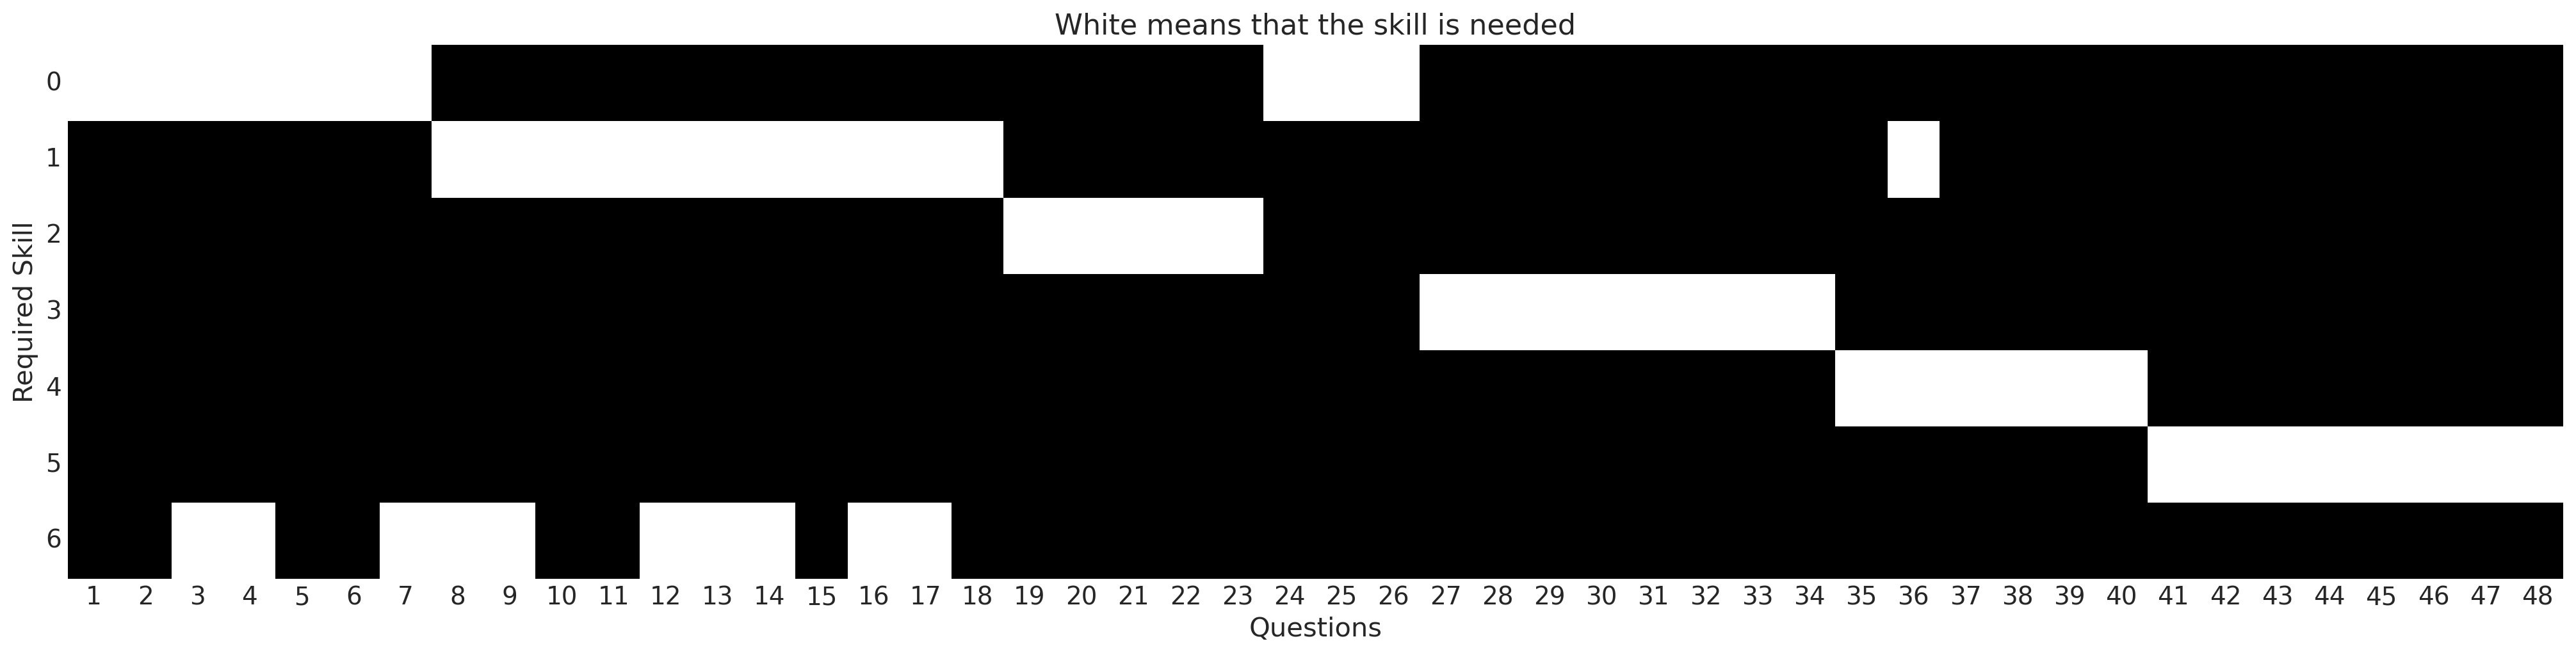

In [18]:
plt.figure(figsize=(20, 5))
sns.heatmap(REQUIRED_SKILLS.T, color='white', cmap=cmap_bw, cbar=False)
_ = plt.xticks(rotation=0)
_ = plt.yticks(rotation=0)
_ = plt.ylabel('Required Skill')
_ = plt.xlabel('Questions')
_ = plt.title('White means that the skill is needed')

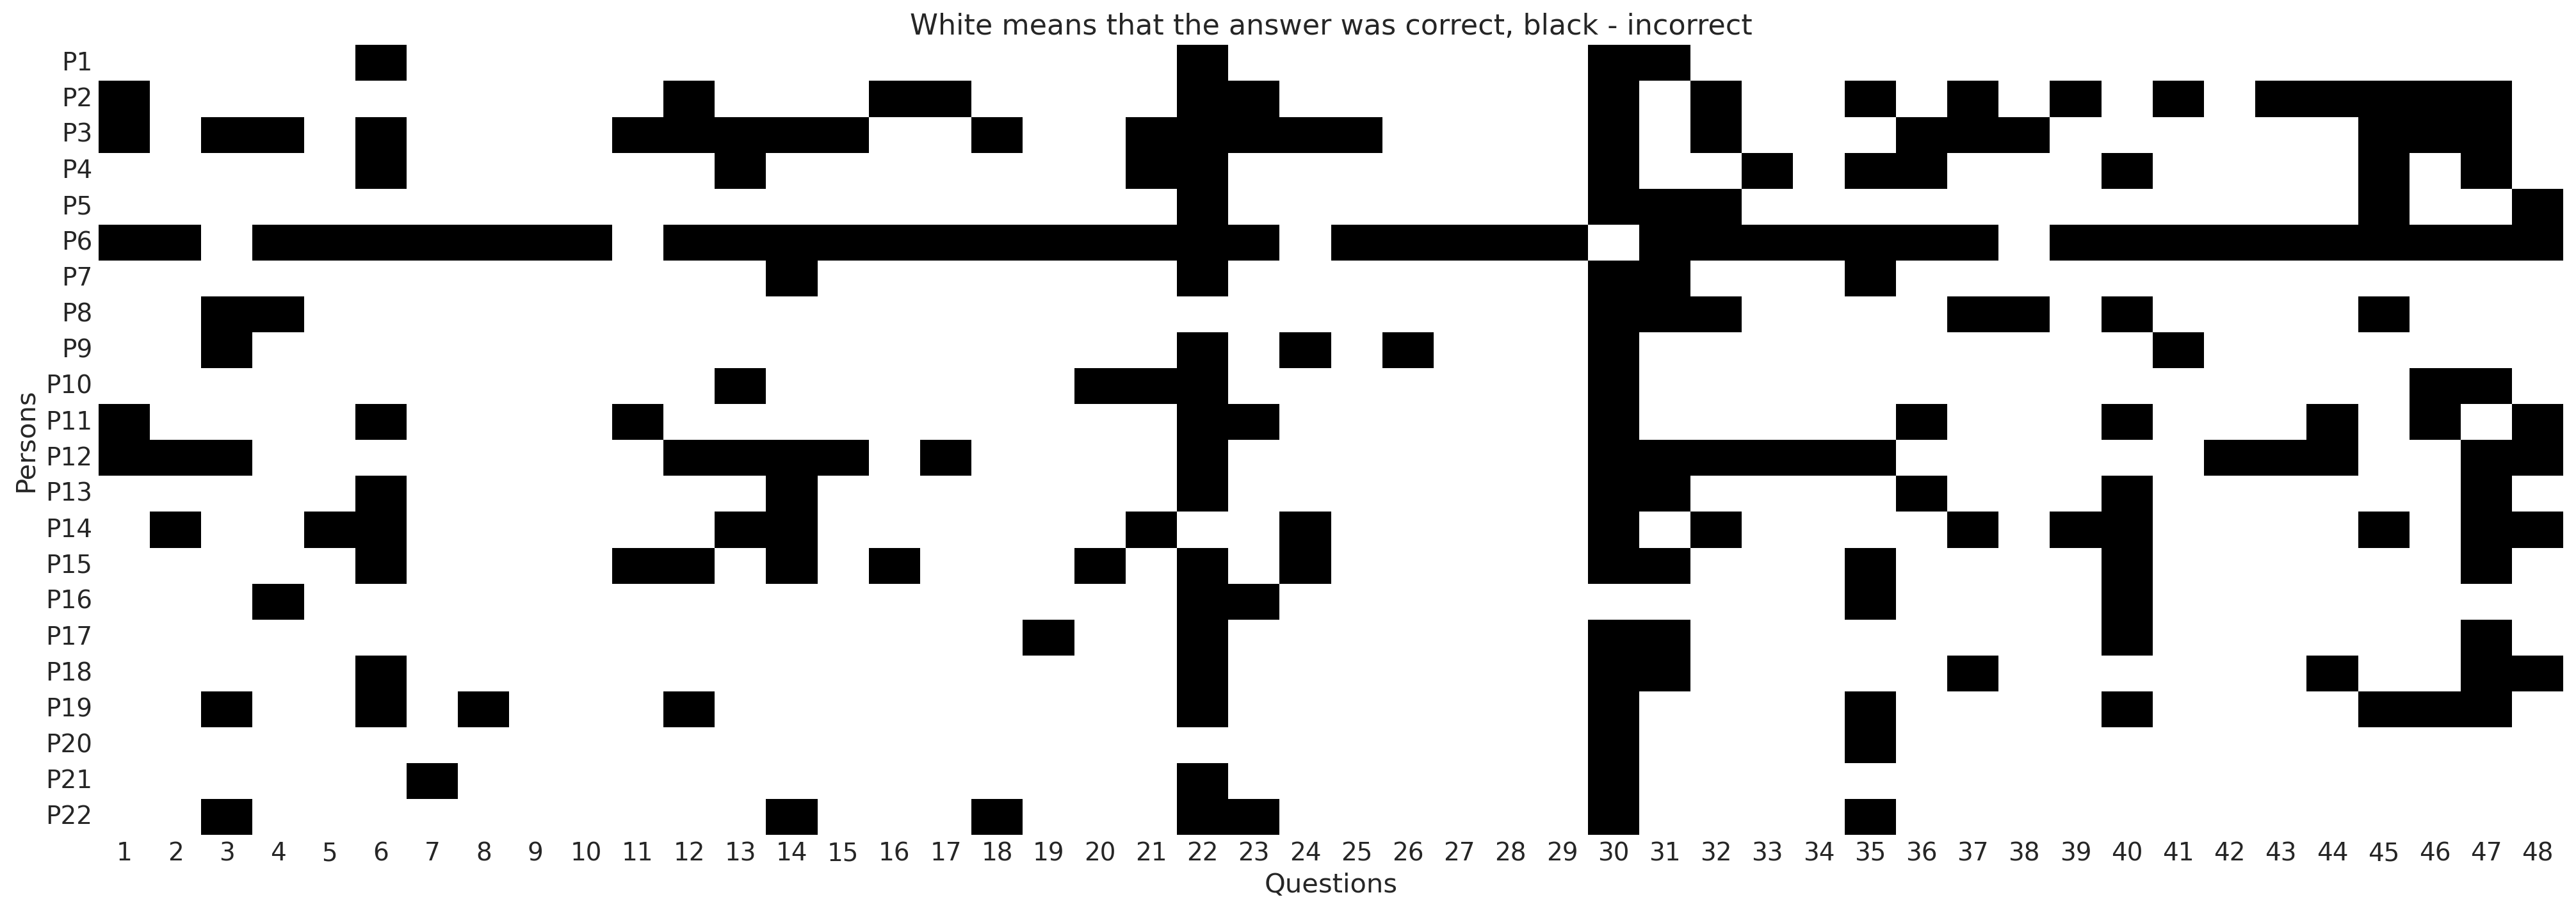

In [19]:
plt.figure(figsize=(20, 7))
sns.heatmap(IS_CORRECT, color='white', cmap=cmap_bw, cbar=False)
_ = plt.xticks(rotation=0)
_ = plt.yticks(rotation=0)
_ = plt.ylabel('Persons')
_ = plt.xlabel('Questions')
_ = plt.title('White means that the answer was correct, black - incorrect')

### First results

In [20]:
IS_CORRECT

,1,2,3,4,5,6,7,8,9,10,...,39,40,41,42,43,44,45,46,47,48
#,,,,,,,,,,,,,,,,,,,,,
P1,1,1,1,1,1,0,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
P2,0,1,1,1,1,1,1,1,1,1,...,0,1,0,1,0,0,0,0,0,1
P3,0,1,0,0,1,0,1,1,1,1,...,1,1,1,1,1,1,0,0,0,1
P4,1,1,1,1,1,0,1,1,1,1,...,1,0,1,1,1,1,0,1,0,1
P5,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,0,1,1,0
P6,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
P7,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
P8,1,1,0,0,1,1,1,1,1,1,...,1,0,1,1,1,1,0,1,1,1
P9,1,1,0,1,1,1,1,1,1,1,...,1,1,0,1,1,1,1,1,1,1


In [21]:
PRIOR_SKILL = 0.5

PROB_RIGHT_GIVEN_SKILL = 0.9
PROB_WRONG_GIVEN_SKILL = 1 - PROB_RIGHT_GIVEN_SKILL

PROB_RIGHT_GIVEN_NO_SKILL= 0.2
PROB_WRONG_GIVEN_NO_SKILL = 1 - PROB_RIGHT_GIVEN_NO_SKILL

In [22]:
PRIOR_SKILL_PEOPLE = PRIOR_SKILL * np.ones((IS_CORRECT.shape[0], REQUIRED_SKILLS.shape[1]))
print(PRIOR_SKILL_PEOPLE.shape)
PRIOR_SKILL_PEOPLE[:3]

(22, 7)


array([[0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5],
       [0.5, 0.5, 0.5, 0.5, 0.5, 0.5, 0.5]])

### Test the vectorised logic

In [23]:
sk = np.ones((IS_CORRECT.shape[0], REQUIRED_SKILLS.shape[1]))
sk[0, :] = 0
sk = pm.math.constant(sk)

sk.shape.eval()

array([22,  7])

In [24]:
req_skills = pm.math.constant(REQUIRED_SKILLS.values)
req_skills.shape.eval()

array([48,  7])

In [25]:
tt.transpose(req_skills).shape.eval()

array([ 7, 48])

In [26]:
n_skills = tt.dot(sk, tt.transpose(req_skills))

In [27]:
n_skills.eval().shape

(22, 48)

In [28]:
n_skills.eval()

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 2., ..., 1., 1., 1.],
       [1., 1., 2., ..., 1., 1., 1.],
       ...,
       [1., 1., 2., ..., 1., 1., 1.],
       [1., 1., 2., ..., 1., 1., 1.],
       [1., 1., 2., ..., 1., 1., 1.]])

In [29]:
n_skills

dot.0

In [30]:
req_skills.sum(axis=1).eval().shape

(48,)

In [31]:
req_skills.sum(axis=1).eval()

array([1, 1, 2, 2, 1, 1, 2, 2, 2, 1, 1, 2, 2, 2, 1, 2, 2, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1])

In [32]:
has_skills = tt.eq(n_skills, req_skills.sum(axis=1))
has_skills.eval().shape

(22, 48)

In [33]:
prob_corect = tt.switch(has_skills, PROB_RIGHT_GIVEN_SKILL, PROB_RIGHT_GIVEN_NO_SKILL)
prob_corect = prob_corect.eval()
prob_corect.shape

(22, 48)

In [34]:
prob_corect

array([[0.2, 0.2, 0.2, ..., 0.2, 0.2, 0.2],
       [0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9],
       ...,
       [0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9],
       [0.9, 0.9, 0.9, ..., 0.9, 0.9, 0.9]])

### Build the model

In [35]:
PRIOR_SKILL_PEOPLE.shape

(22, 7)

In [36]:
REQUIRED_SKILLS.shape

(48, 7)

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 94 seconds.
/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


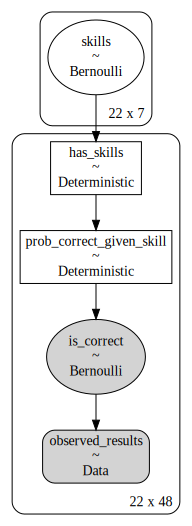

In [37]:
with pm.Model(coords={'questions': IS_CORRECT.columns, 'persons': IS_CORRECT.index}) as model:
        
    skills = pm.Bernoulli('skills',p=PRIOR_SKILL_PEOPLE, shape=PRIOR_SKILL_PEOPLE.shape) # n_people x n_skills
    required_skills = pm.math.constant(REQUIRED_SKILLS, name='required_skills')          # n_quest x n_skills

    n_skills_present = pm.math.dot(skills, tt.transpose(required_skills))                # n_people x n_questions
    n_skills_required = required_skills.sum(axis=1)                                      # n_questions                                 
    has_skills = pm.Deterministic('has_skills', pm.math.eq(n_skills_present, n_skills_required)) # n_people x n_questions
    prob_correct_given_skill = pm.Deterministic('prob_correct_given_skill', pm.math.switch(has_skills,
                                                                                           PROB_RIGHT_GIVEN_SKILL,
                                                                                           PROB_RIGHT_GIVEN_NO_SKILL))
        
    observed_results = pm.Data('observed_results', IS_CORRECT, dims=('persons', 'questions'))
    is_correct = pm.Bernoulli('is_correct', prob_correct_given_skill, observed=observed_results, dims=('persons', 'questions'))


    trace = pm.sample(10000, return_inferencedata=True)
pm.model_to_graphviz(model)

In [38]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> observed_data
	> constant_data

In [39]:
trace['posterior']['skills'].shape

(4, 10000, 22, 7)

In [40]:
trace['posterior']['skills'].mean(axis=1).shape

(4, 22, 7)

In [41]:
trace['posterior']['skills'].mean(axis=1).mean(axis=0).shape

(22, 7)

In [42]:
post_prob_skills = trace['posterior']['skills'].mean(axis=1).mean(axis=0).values
post_prob_skills.shape

(22, 7)

In [43]:
CMAP_BW = sns.color_palette("Greys_r", as_cmap=True)

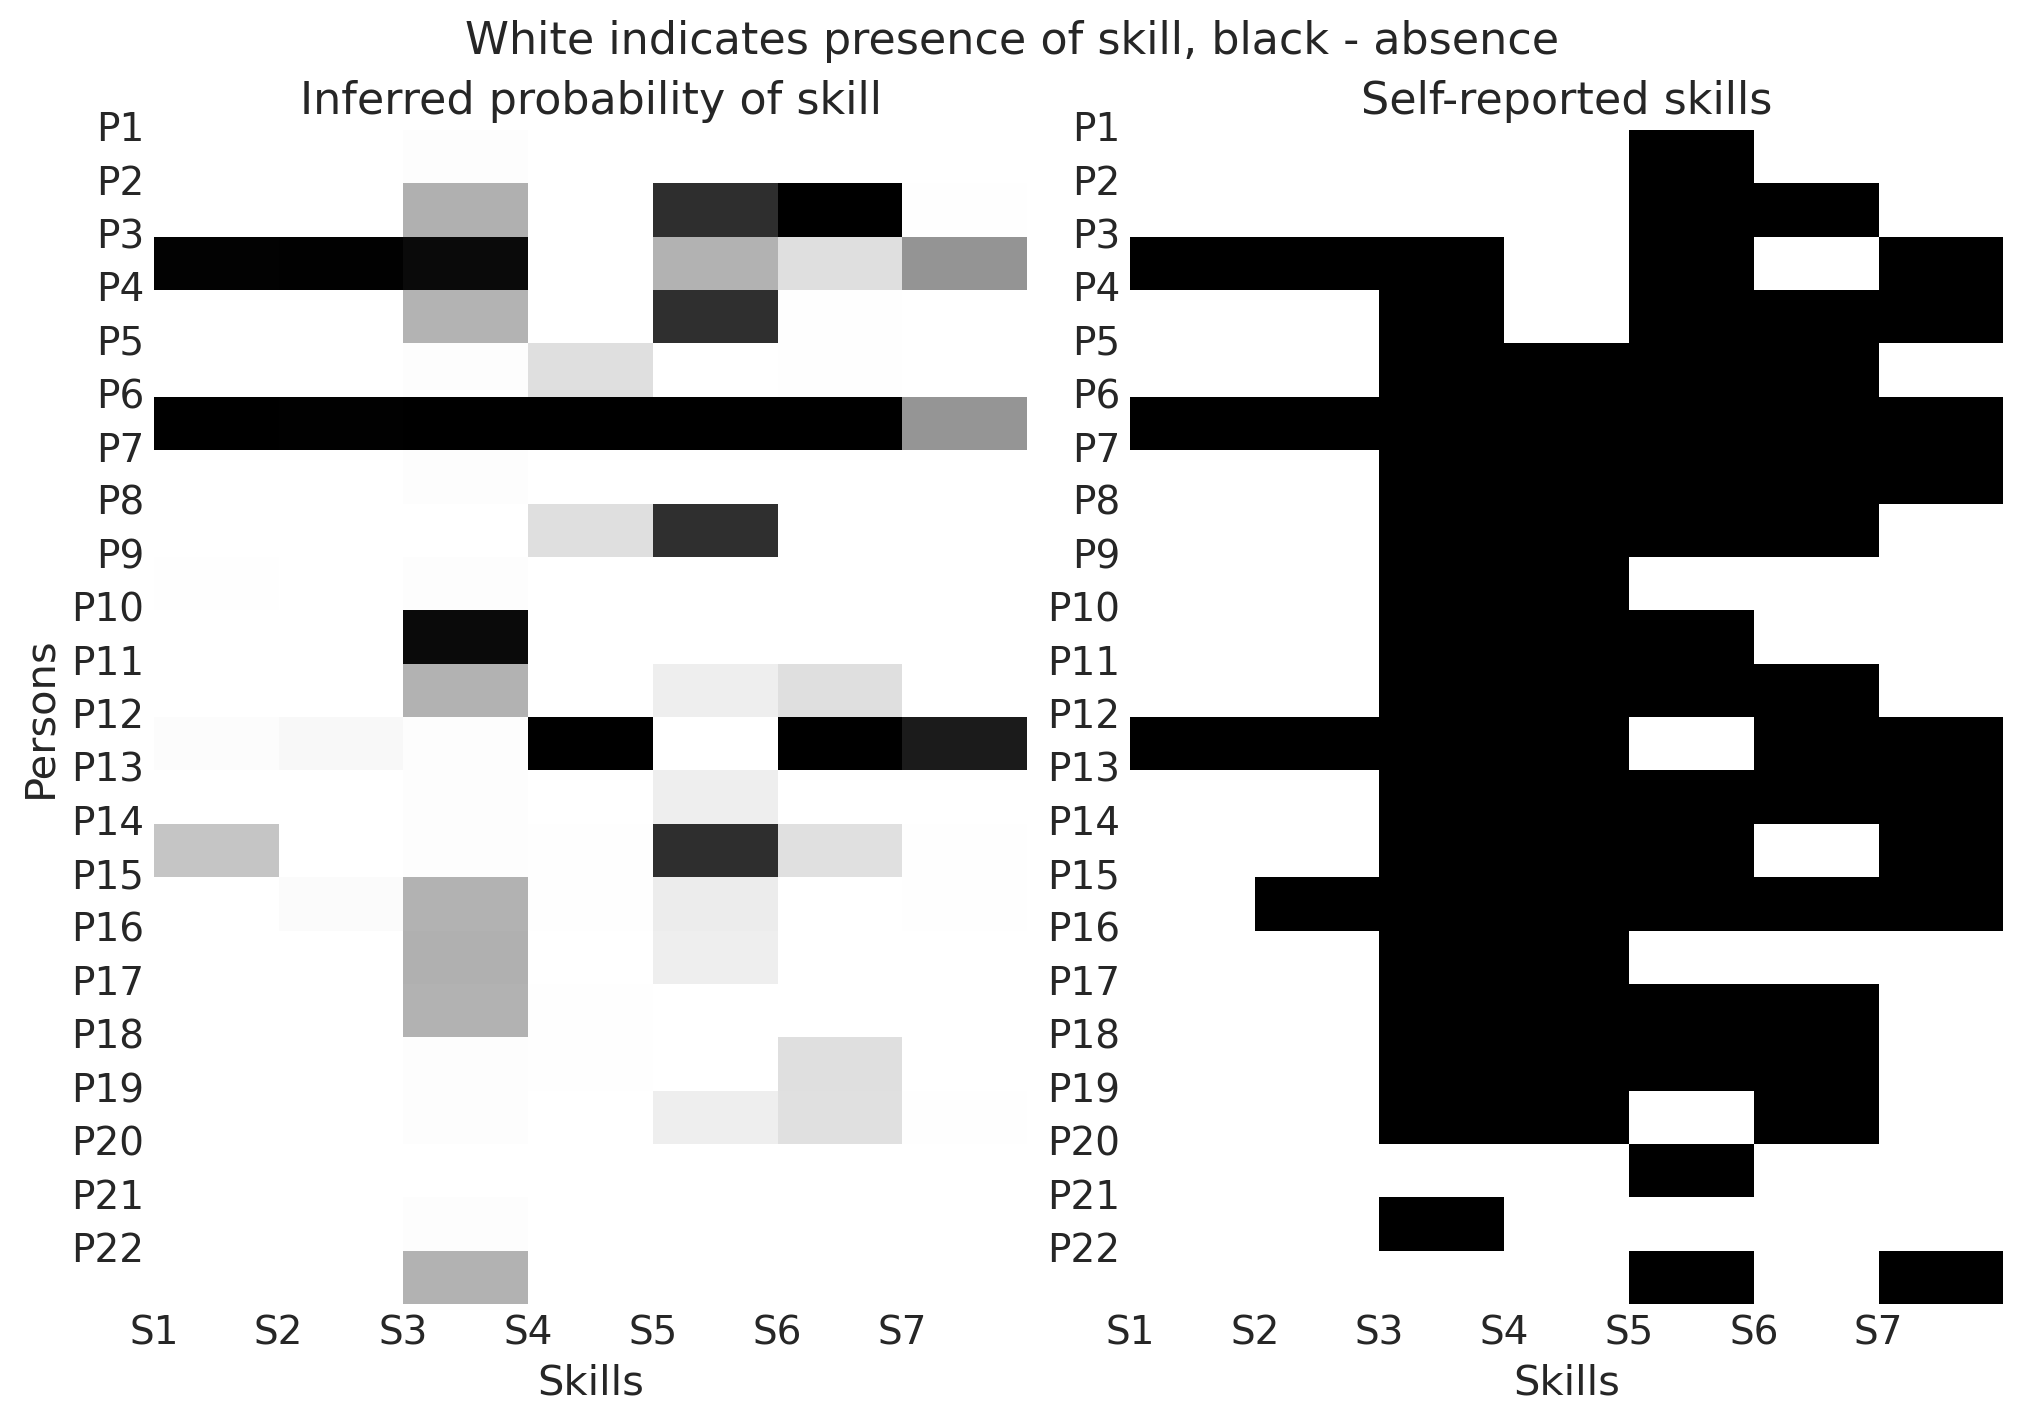

In [44]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('White indicates presence of skill, black - absence', fontsize=16)

xticks = HAS_SKILLS.columns
yticks = HAS_SKILLS.index


ax1 = fig.add_subplot(121)
sns.heatmap(post_prob_skills, color='white', ax=ax1, cmap=CMAP_BW, cbar=False)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('Persons')
_ = plt.xlabel('Skills')
_ = plt.title('Inferred probability of skill')


ax2 = fig.add_subplot(122)
sns.heatmap(HAS_SKILLS.astype(int), color='white', cmap=CMAP_BW, ax=ax2, cbar=False)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('')
_ = plt.xlabel('Skills')
_ = plt.title('Self-reported skills')

### The inferred results deviate substantially from the ground truth

## 5. Diagnosing the problem

    When a machine learning system is not working there are generally three possible reasons: bad data, bad model, or bad inference. Here are some common causes of problems under each of these three headings:

    Bad data:
        data items have been entered, stored or loaded incorrectly; the data items are incomplete or mislabelled; data values are too noisy to be useful; the data is biased or unrepresentative of how the system will be used; it is the wrong data for the task; there is insufficient data to make accurate predictions. 
    
    Bad model:
        one or more of the modelling assumptions are wrong – that is, not consistent with the actual process that generated the data; the model makes too many simplifying assumptions; the model contains insufficient assumptions to make accurate predictions given the amount of available data. 
    
    Bad inference:
        the inference code contains a bug; the message-passing schedule is bad; the inference has not converged; there are numerical problems (e.g. rounding, overflow); the approximate inference algorithm is not accurate enough. 

The data is all right, problem is either with model or inference.

To test the inference algorithm, generate synthetic data and see if the inferred results match it.

In [45]:
sim_data = pm.sample_prior_predictive(samples=10, model=model, random_seed=9332)
sim_data.keys()

dict_keys(['is_correct', 'prob_correct_given_skill', 'skills', 'has_skills'])

In [46]:
sim_data['skills'].mean(axis=0).shape

(22, 7)

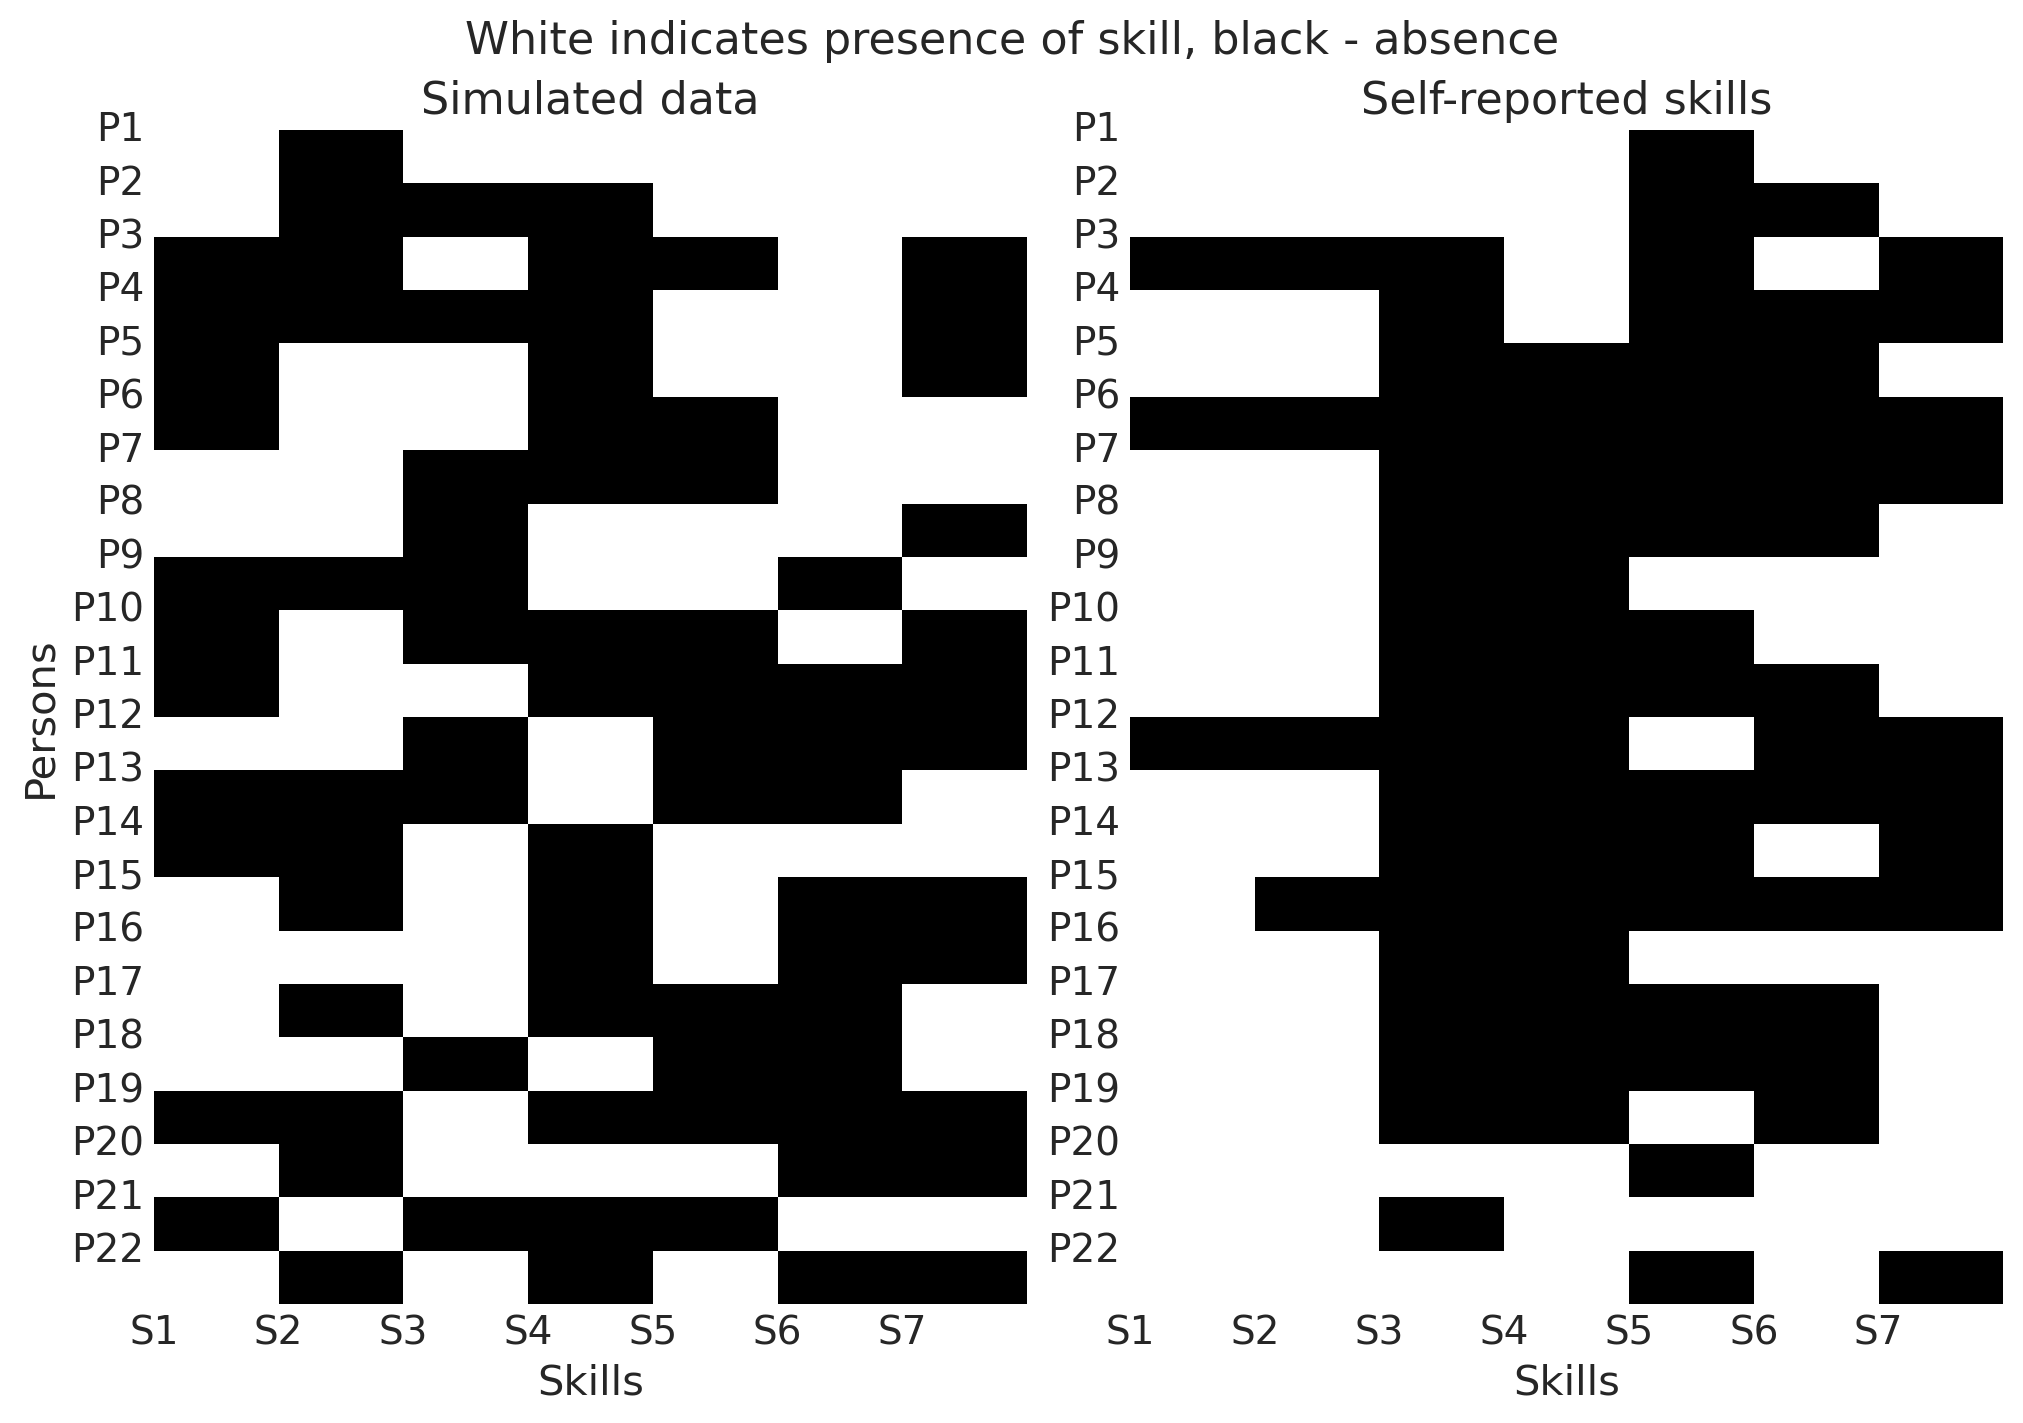

In [47]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('White indicates presence of skill, black - absence', fontsize=16)

xticks = HAS_SKILLS.columns
yticks = HAS_SKILLS.index


ax1 = fig.add_subplot(121)
sns.heatmap(sim_data['skills'][0], color='white', ax=ax1, cmap=CMAP_BW, cbar=False)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('Persons')
_ = plt.xlabel('Skills')
_ = plt.title('Simulated data')


ax2 = fig.add_subplot(122)
sns.heatmap(HAS_SKILLS.astype(int), color='white', cmap=CMAP_BW, ax=ax2, cbar=False)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('')
_ = plt.xlabel('Skills')
_ = plt.title('Self-reported skills')

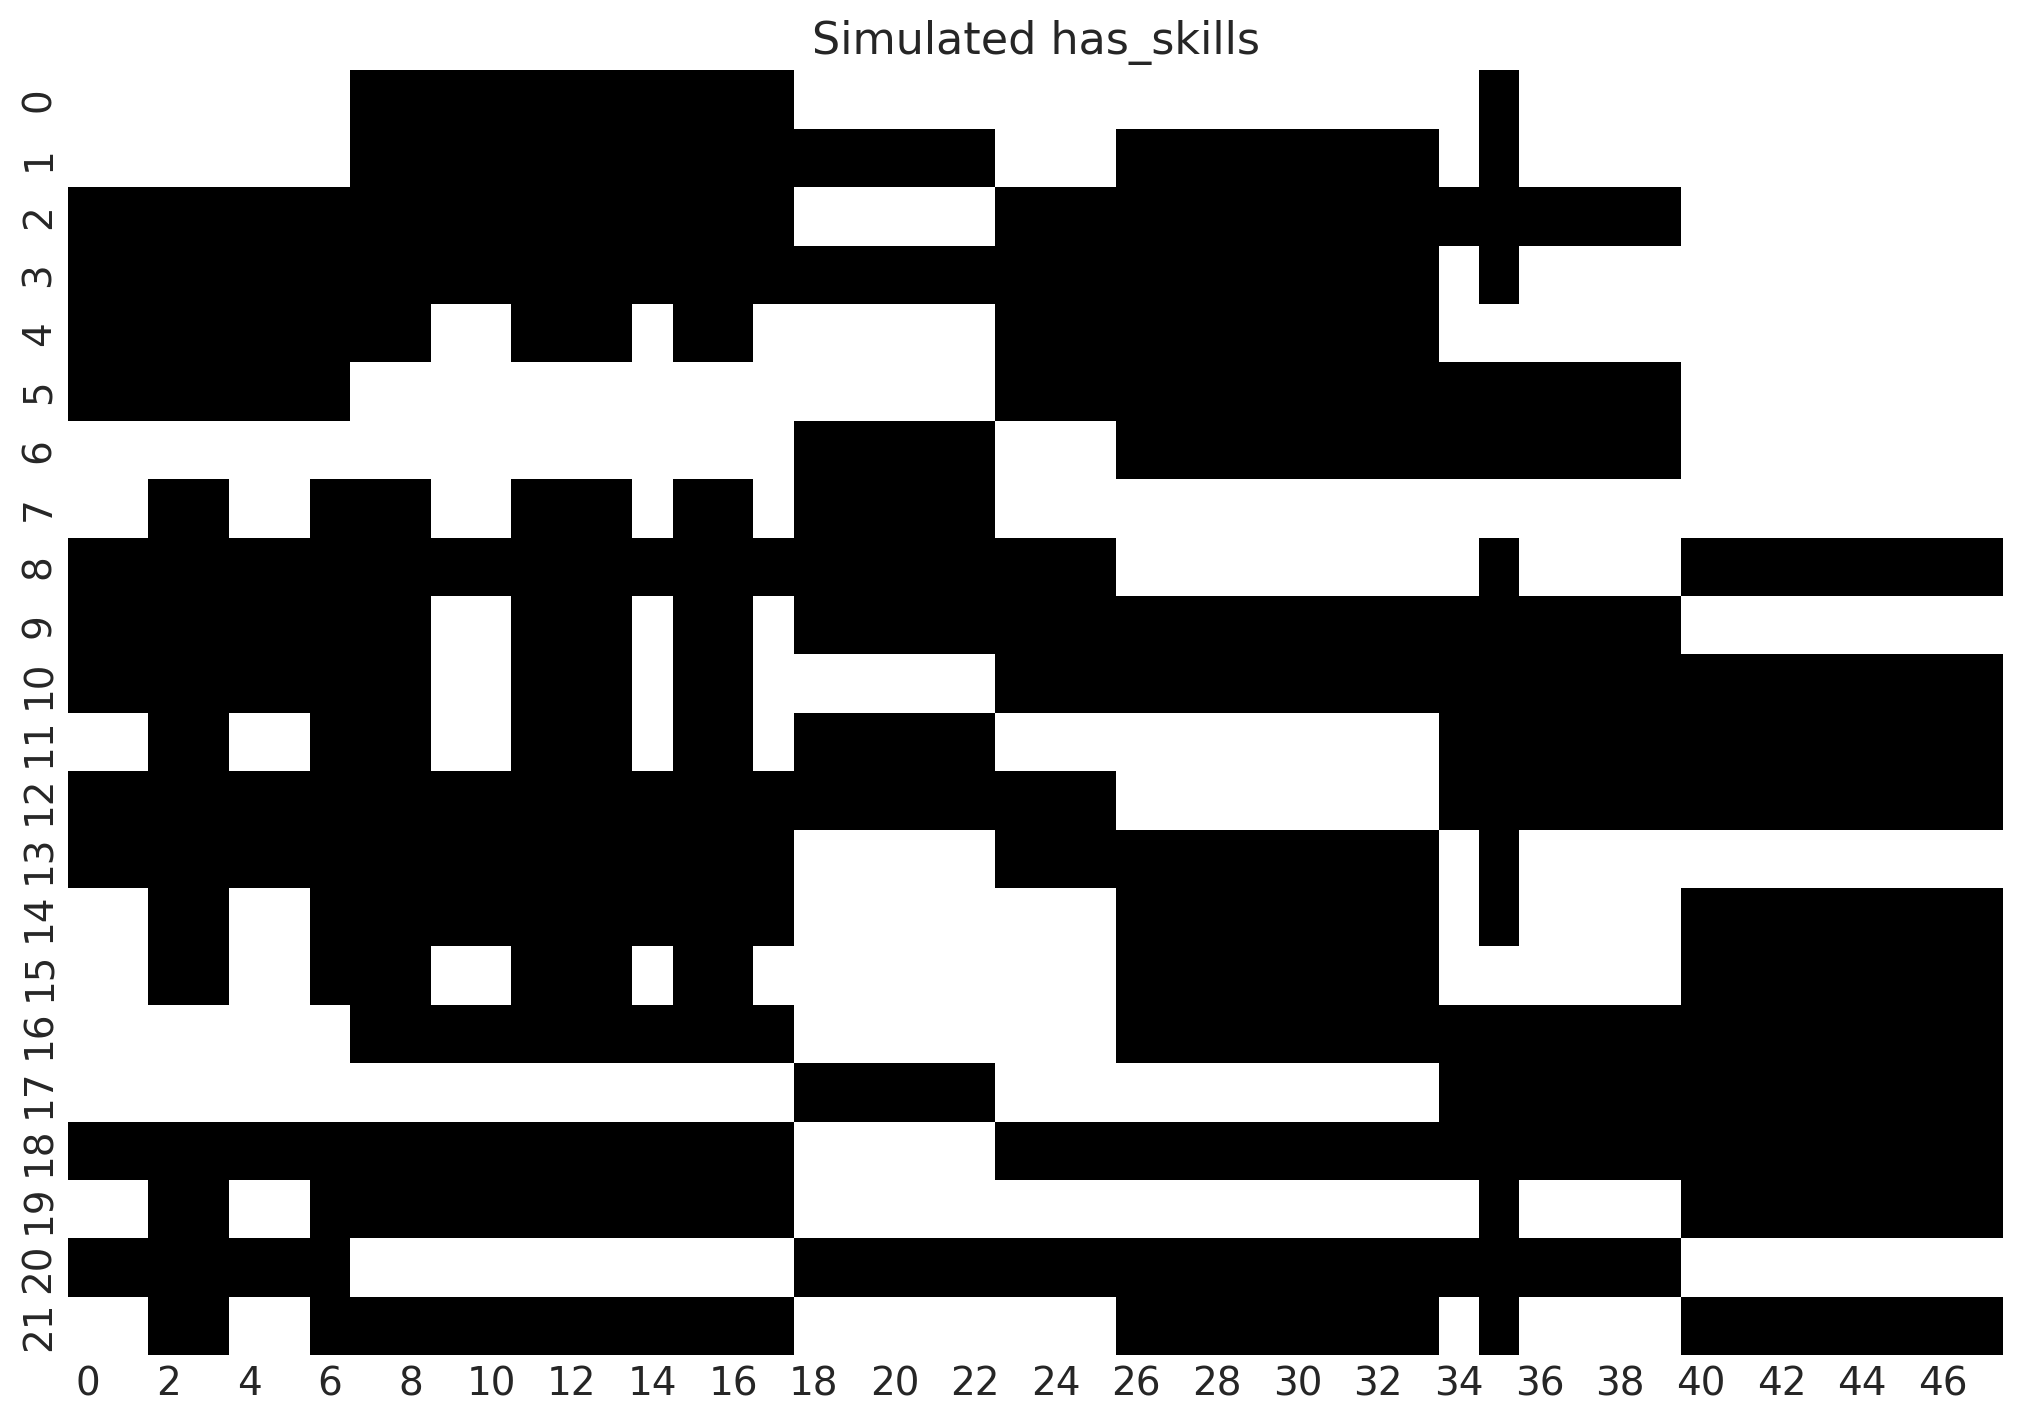

In [48]:
fig = plt.figure(figsize=(10, 7))
sns.heatmap(sim_data['has_skills'][0], color='white', cmap=CMAP_BW, cbar=False)
_ = plt.title('Simulated has_skills')

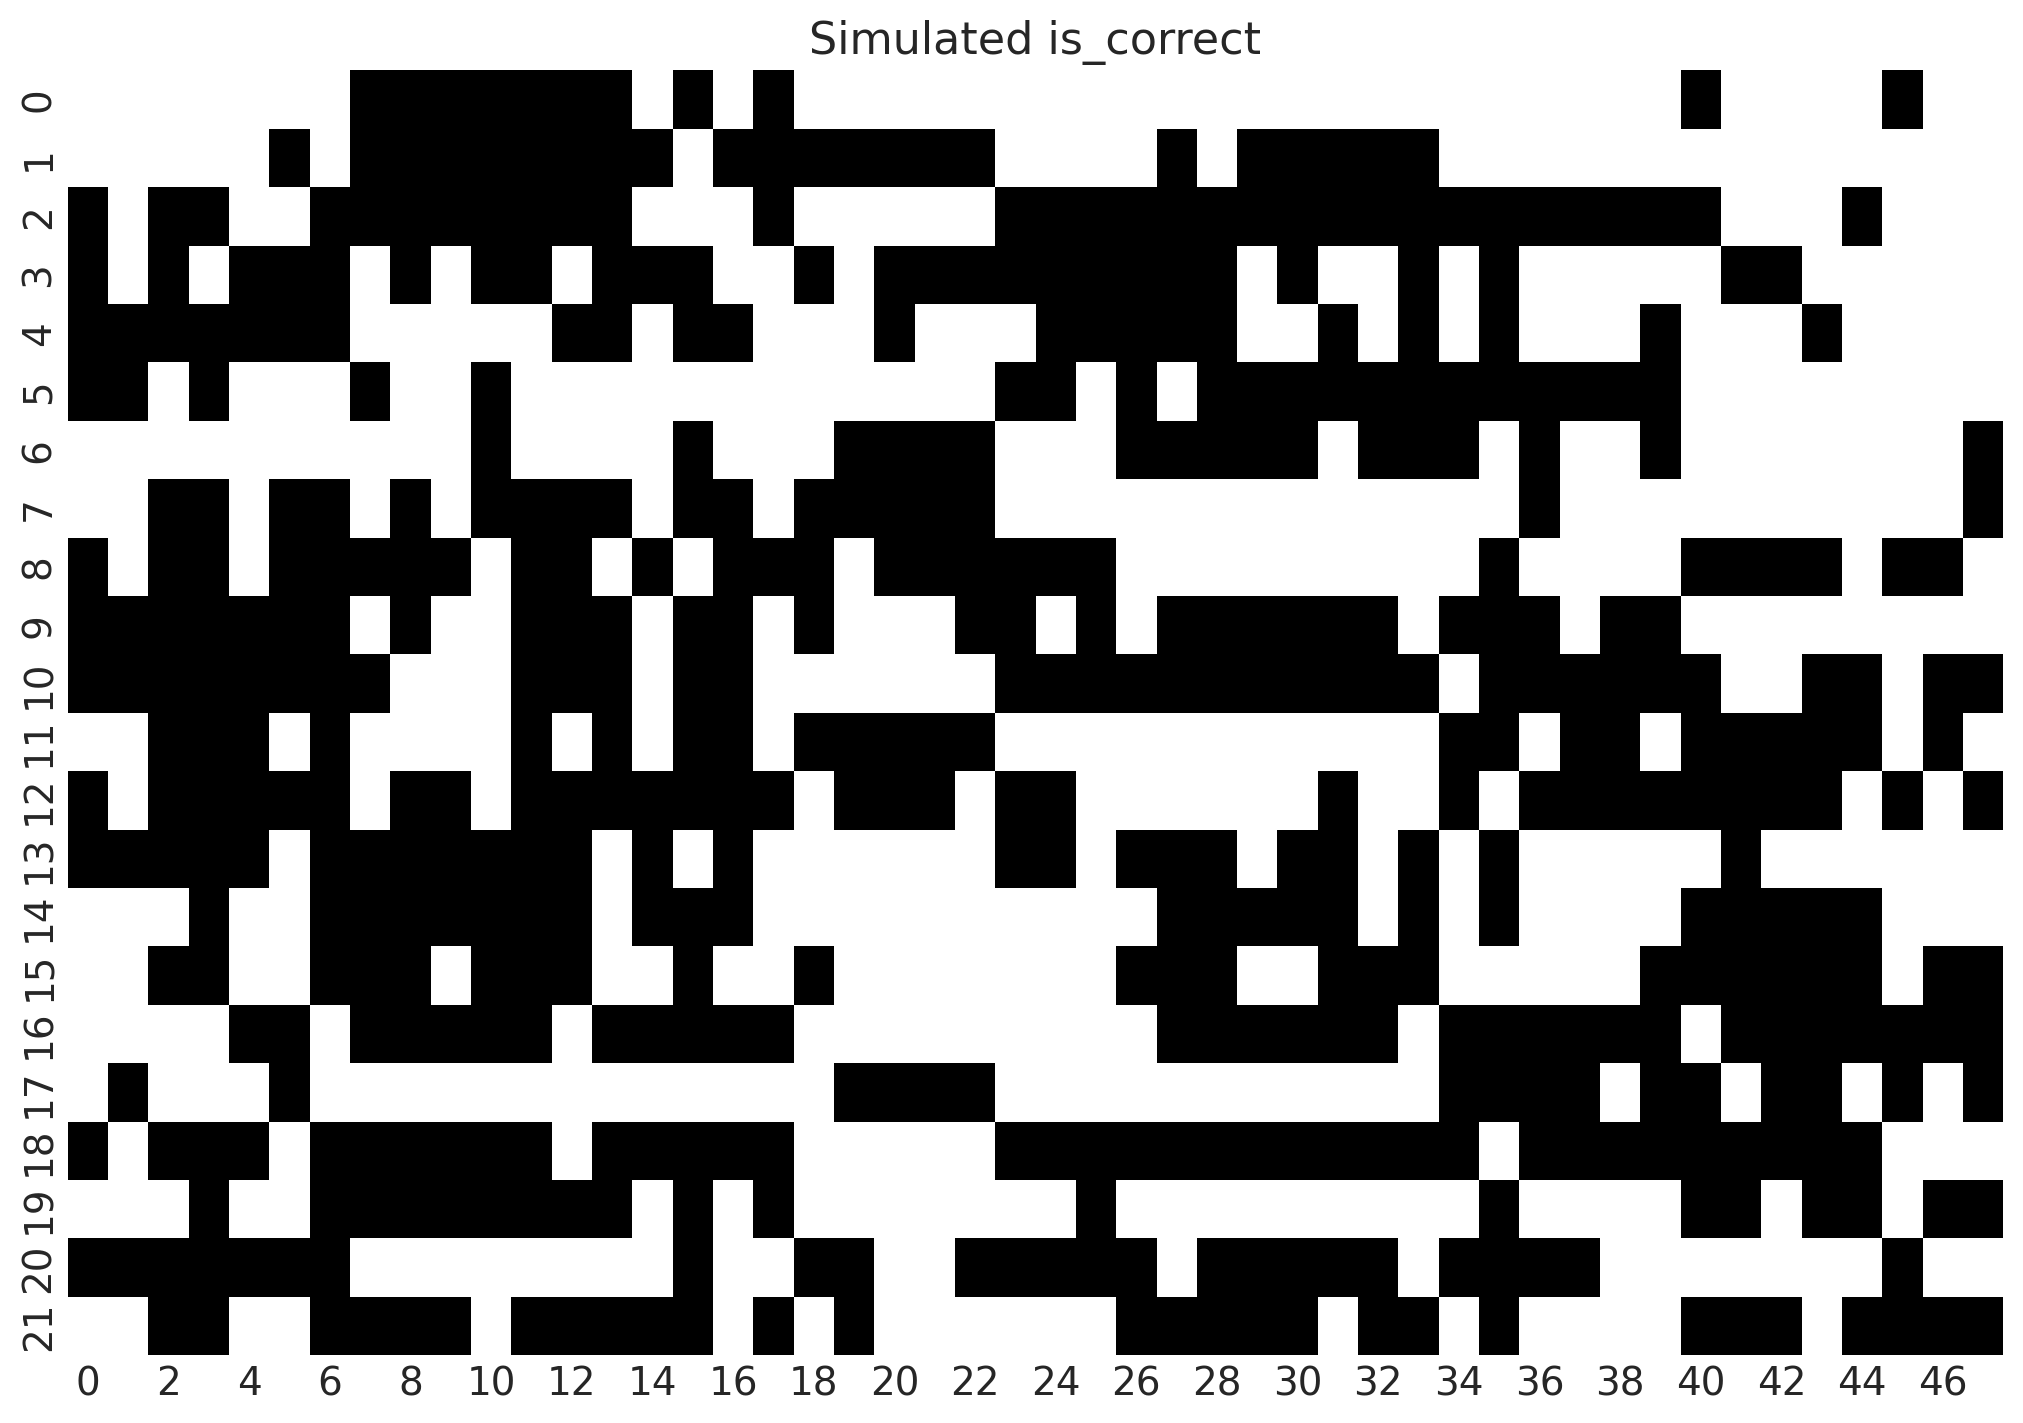

In [49]:
fig = plt.figure(figsize=(10, 7))
sns.heatmap(sim_data['is_correct'][0], color='white', cmap=CMAP_BW, cbar=False)
_ = plt.title('Simulated is_correct')

### Run inference on the simulated data

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [skills]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 94 seconds.
/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


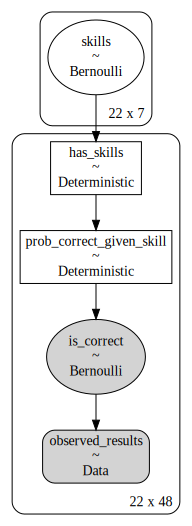

In [50]:
with pm.Model(coords={'questions': IS_CORRECT.columns, 'persons': IS_CORRECT.index}) as model:
        
    skills = pm.Bernoulli('skills',p=PRIOR_SKILL_PEOPLE, shape=PRIOR_SKILL_PEOPLE.shape) # n_people x n_skills
    required_skills = pm.math.constant(REQUIRED_SKILLS, name='required_skills')          # n_quest x n_skills

    n_skills_present = pm.math.dot(skills, tt.transpose(required_skills))                # n_people x n_questions
    n_skills_required = required_skills.sum(axis=1)                                      # n_questions                                 
    has_skills = pm.Deterministic('has_skills', pm.math.eq(n_skills_present, n_skills_required)) # n_people x n_questions
    prob_correct_given_skill = pm.Deterministic('prob_correct_given_skill', pm.math.switch(has_skills,
                                                                                           PROB_RIGHT_GIVEN_SKILL,
                                                                                           PROB_RIGHT_GIVEN_NO_SKILL))
        
    observed_results = pm.Data('observed_results', sim_data['is_correct'][0], dims=('persons', 'questions'))
    is_correct = pm.Bernoulli('is_correct', prob_correct_given_skill, observed=observed_results, dims=('persons', 'questions'))


    trace = pm.sample(10000, return_inferencedata=True)
pm.model_to_graphviz(model)

### Compare inferred skills matrix with the ground truth (simulated)

In [51]:
post_prob_skills = trace['posterior']['skills'].mean(axis=1).mean(axis=0).values
post_prob_skills.shape

(22, 7)

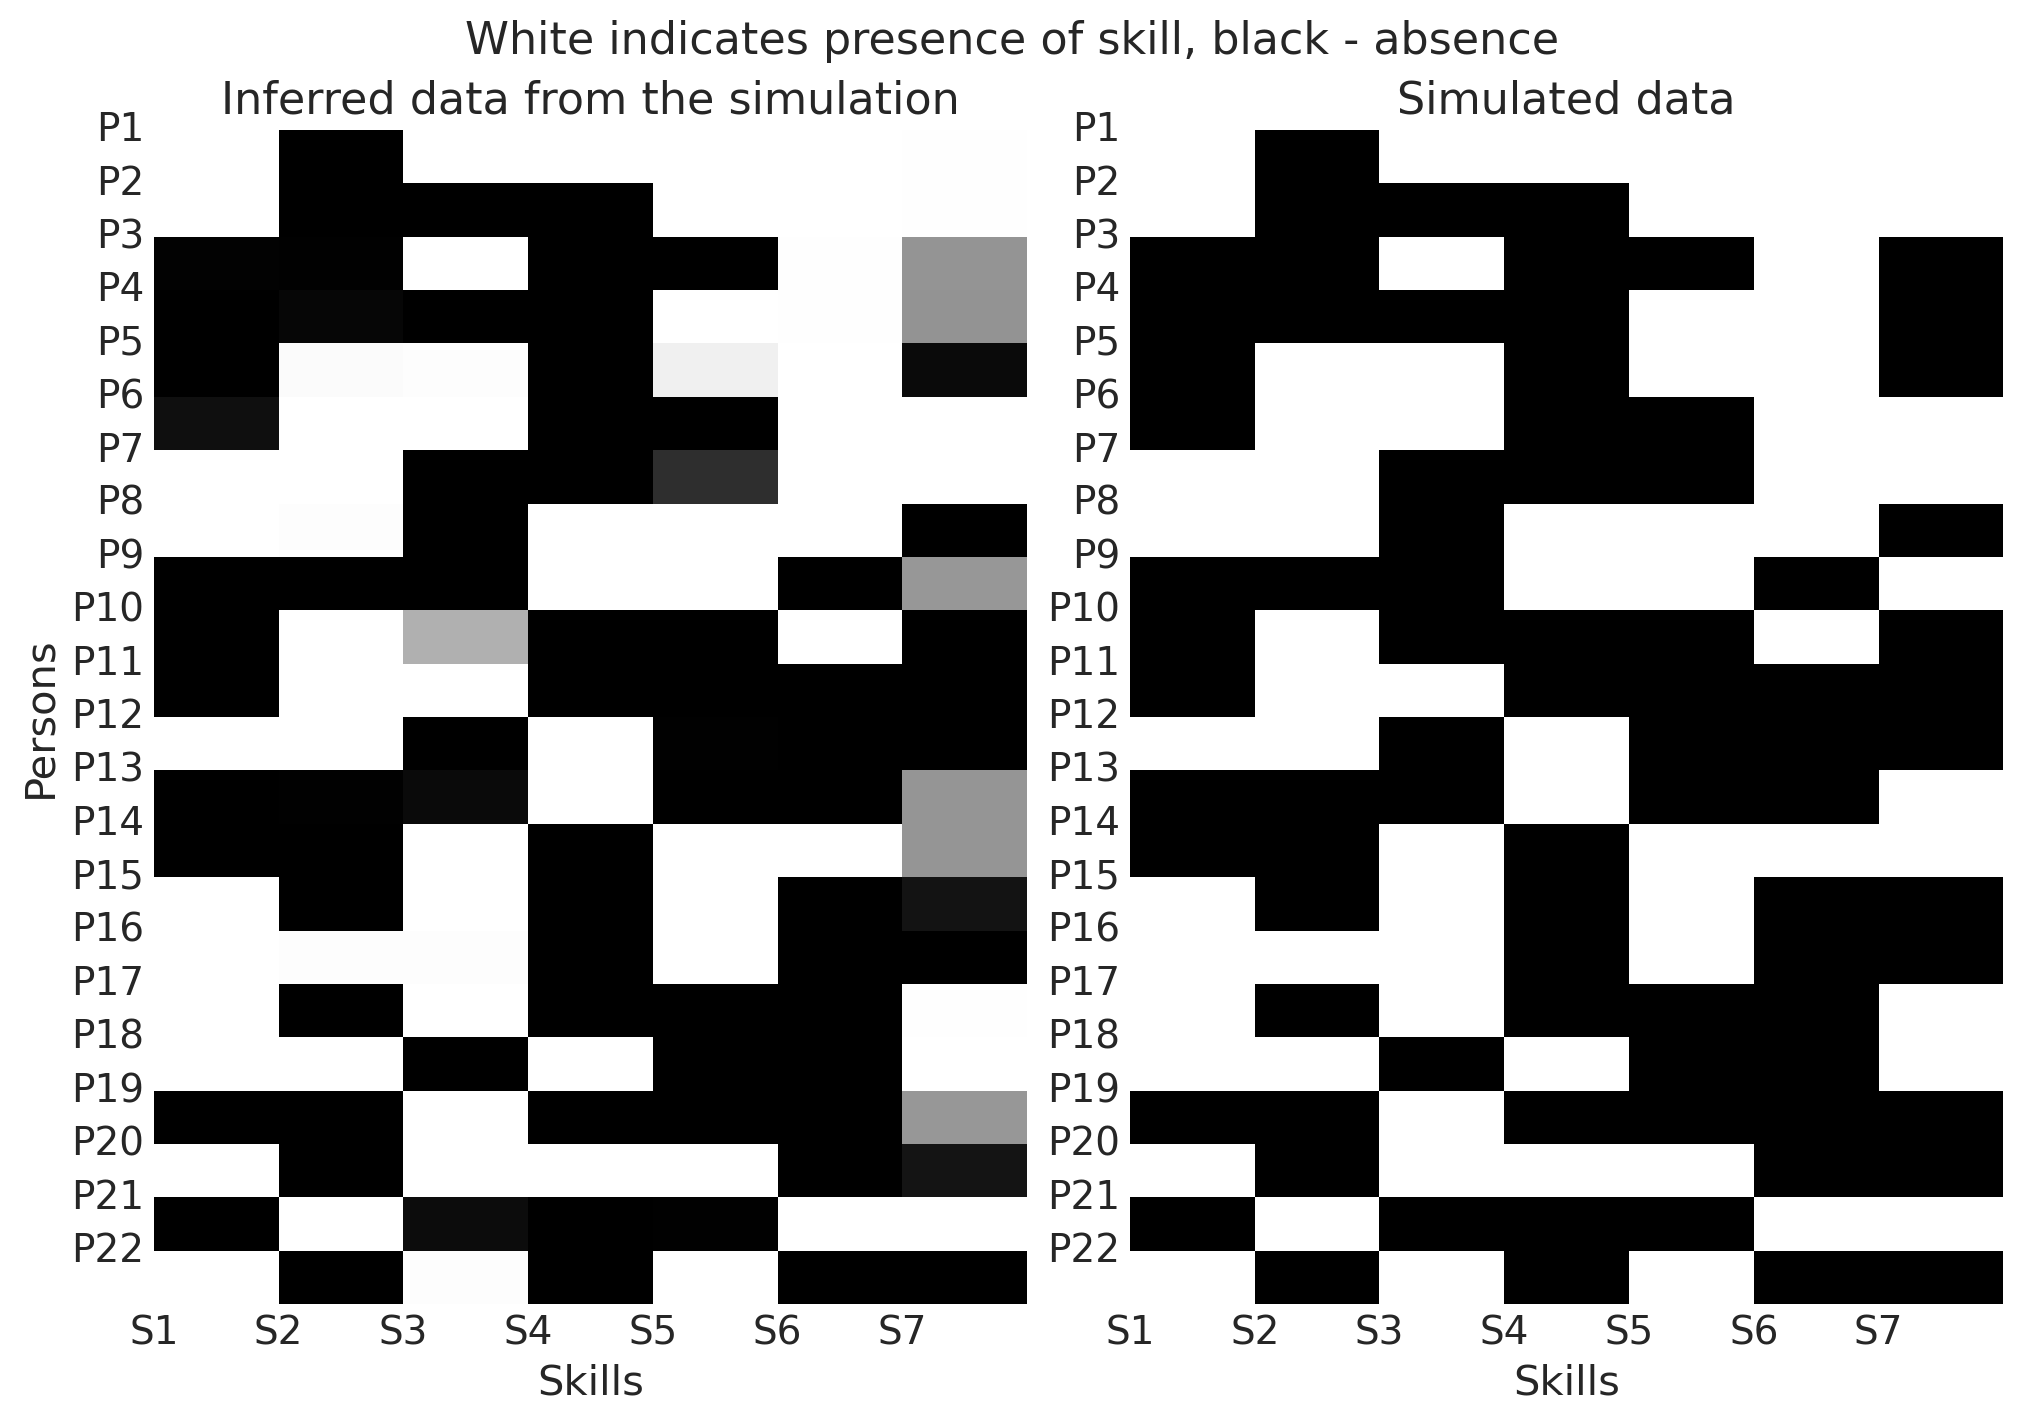

In [52]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('White indicates presence of skill, black - absence', fontsize=16)

xticks = HAS_SKILLS.columns
yticks = HAS_SKILLS.index


ax1 = fig.add_subplot(121)
sns.heatmap(post_prob_skills, color='white', ax=ax1, cmap=CMAP_BW, cbar=False)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('Persons')
_ = plt.xlabel('Skills')
_ = plt.title('Inferred data from the simulation')


ax2 = fig.add_subplot(122)
sns.heatmap(sim_data['skills'][0], color='white', cmap=CMAP_BW, ax=ax2, cbar=False)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('')
_ = plt.xlabel('Skills')
_ = plt.title('Simulated data')

**The inference algorithm seems to work, as it perfectly recovered the simulated data.**


## 6. [Learning the guess probabilities](https://mbmlbook.com/LearningSkills_Learning_the_guess_probabilities.html)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [skills]
>NUTS: [prob_guess]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 128 seconds.
/Users/amosin/opt/anaconda3/envs/pymc3_env/lib/python3.9/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 25% for some parameters.


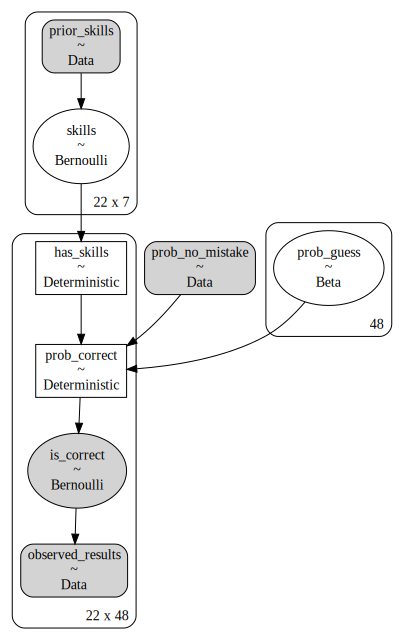

In [53]:
with pm.Model(coords={'questions': IS_CORRECT.columns,
                      'persons': IS_CORRECT.index,
                      'skills': HAS_SKILLS.columns}) as model:

    prior_skills = pm.Data('prior_skills', PRIOR_SKILL_PEOPLE, dims=('persons', 'skills'))
    skills = pm.Bernoulli('skills',p=prior_skills, shape=PRIOR_SKILL_PEOPLE.shape)       # n_people x n_skills
    required_skills = pm.math.constant(REQUIRED_SKILLS, name='required_skills')          # n_quest x n_skills

    n_skills_present = pm.math.dot(skills, tt.transpose(required_skills))                # n_people x n_questions
    n_skills_required = required_skills.sum(axis=1)                                      # n_questions                                 
    has_skills = pm.Deterministic('has_skills', pm.math.eq(n_skills_present, n_skills_required)) # n_people x n_questions
    
    
    #prob_right_given_skill = pm.Constant('prob_no_mistake', PROB_RIGHT_GIVEN_SKILL) # model init failed if defined like this
    prob_right_given_skill = pm.Data('prob_no_mistake', PROB_RIGHT_GIVEN_SKILL)
    prob_right_given_no_skill = pm.Beta('prob_guess', alpha=2.5, beta=7.5, dims='questions')    
    prob_correct = pm.Deterministic('prob_correct', pm.math.switch(has_skills,
                                                                   prob_right_given_skill,
                                                                   prob_right_given_no_skill))
    # likelihood
    observed_results = pm.Data('observed_results', IS_CORRECT, dims=('persons', 'questions')) 
    is_correct = pm.Bernoulli('is_correct', p=prob_correct, observed=observed_results, dims=('persons', 'questions'))    
    
    trace = pm.sample(10000, return_inferencedata=True)
pm.model_to_graphviz(model)

In [54]:
trace

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data
	> constant_data

In [55]:
trace['posterior']['prob_guess'].shape

(4, 10000, 48)

<AxesSubplot:>

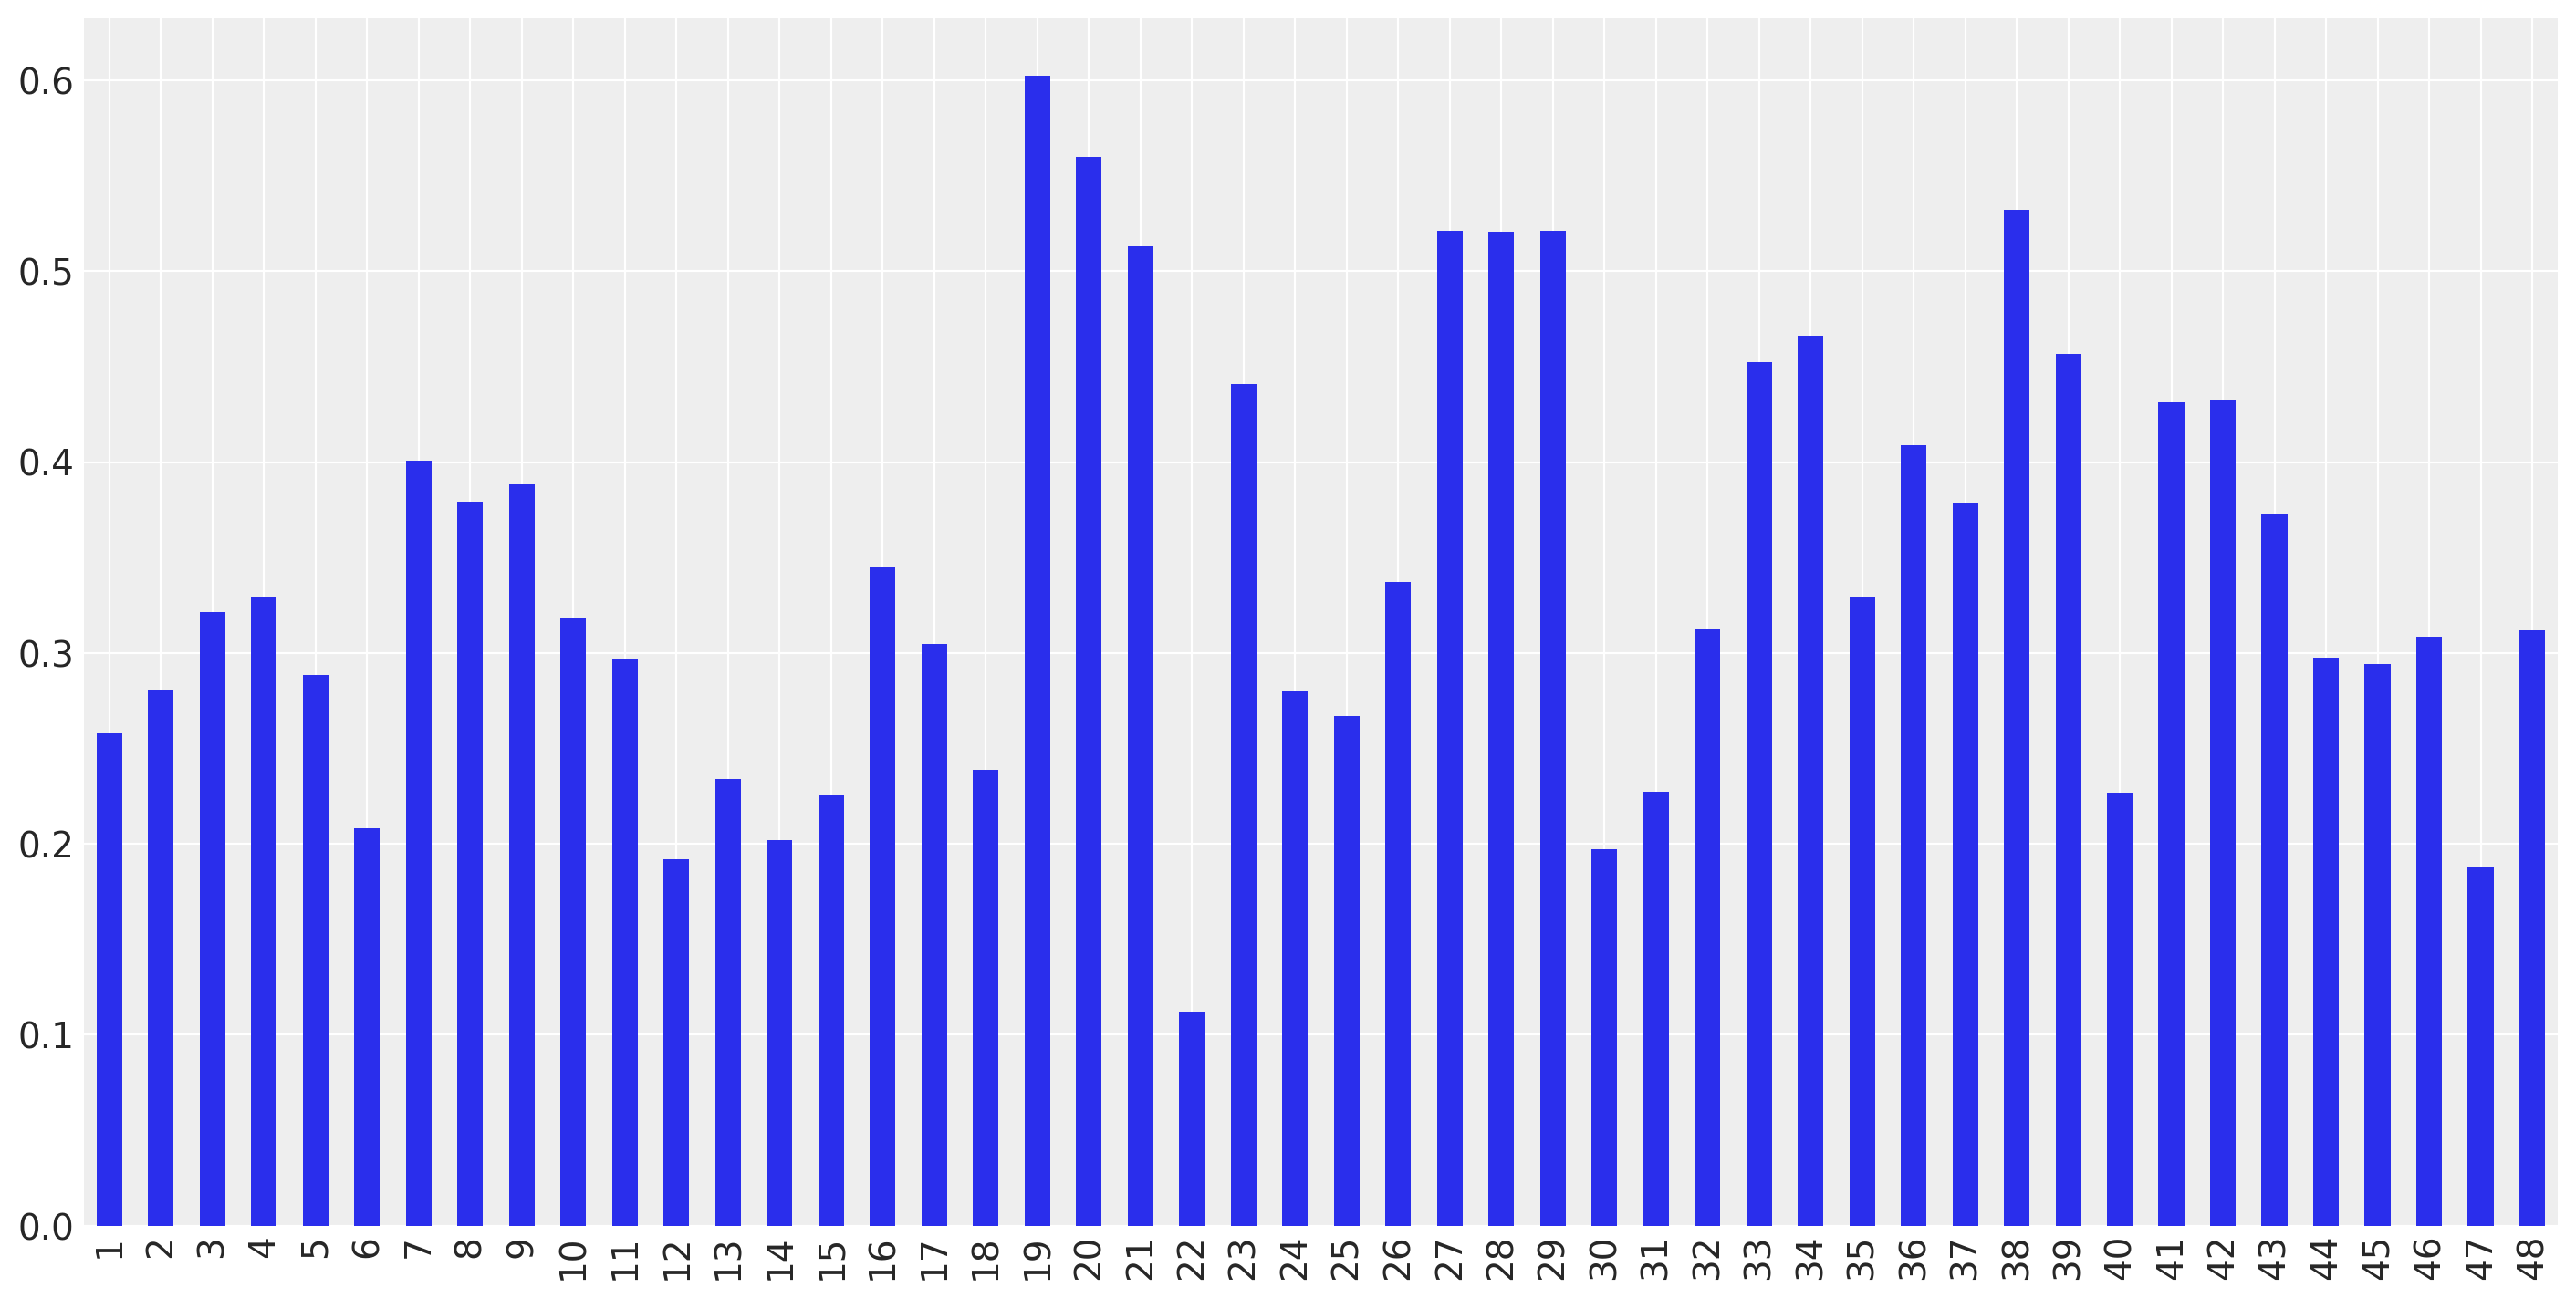

In [56]:
fig = plt.figure(figsize=(14, 7))
pd.Series(trace['posterior']['prob_guess'].mean(axis=1).mean(axis=0).values, index=IS_CORRECT.columns).plot(kind='bar')

In [57]:
d = pd.DataFrame(trace['posterior']['prob_guess'].mean(axis=0), columns=IS_CORRECT.columns)

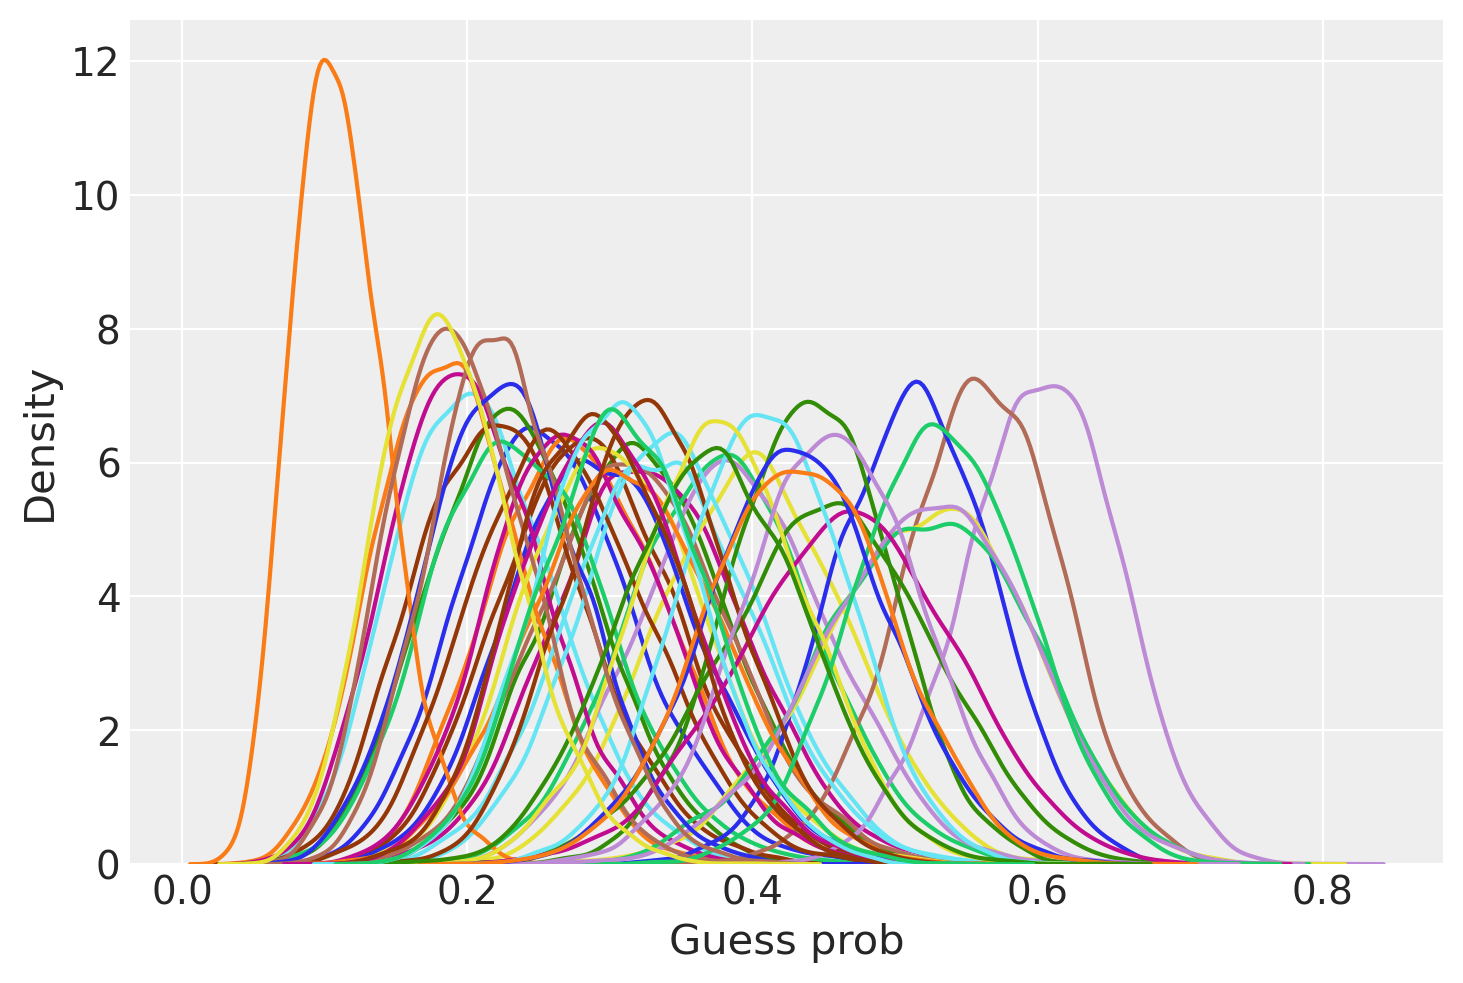

In [58]:
for q in d.columns:
    sns.kdeplot(d[q], label=q)
_ = plt.xlabel('Guess prob')

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

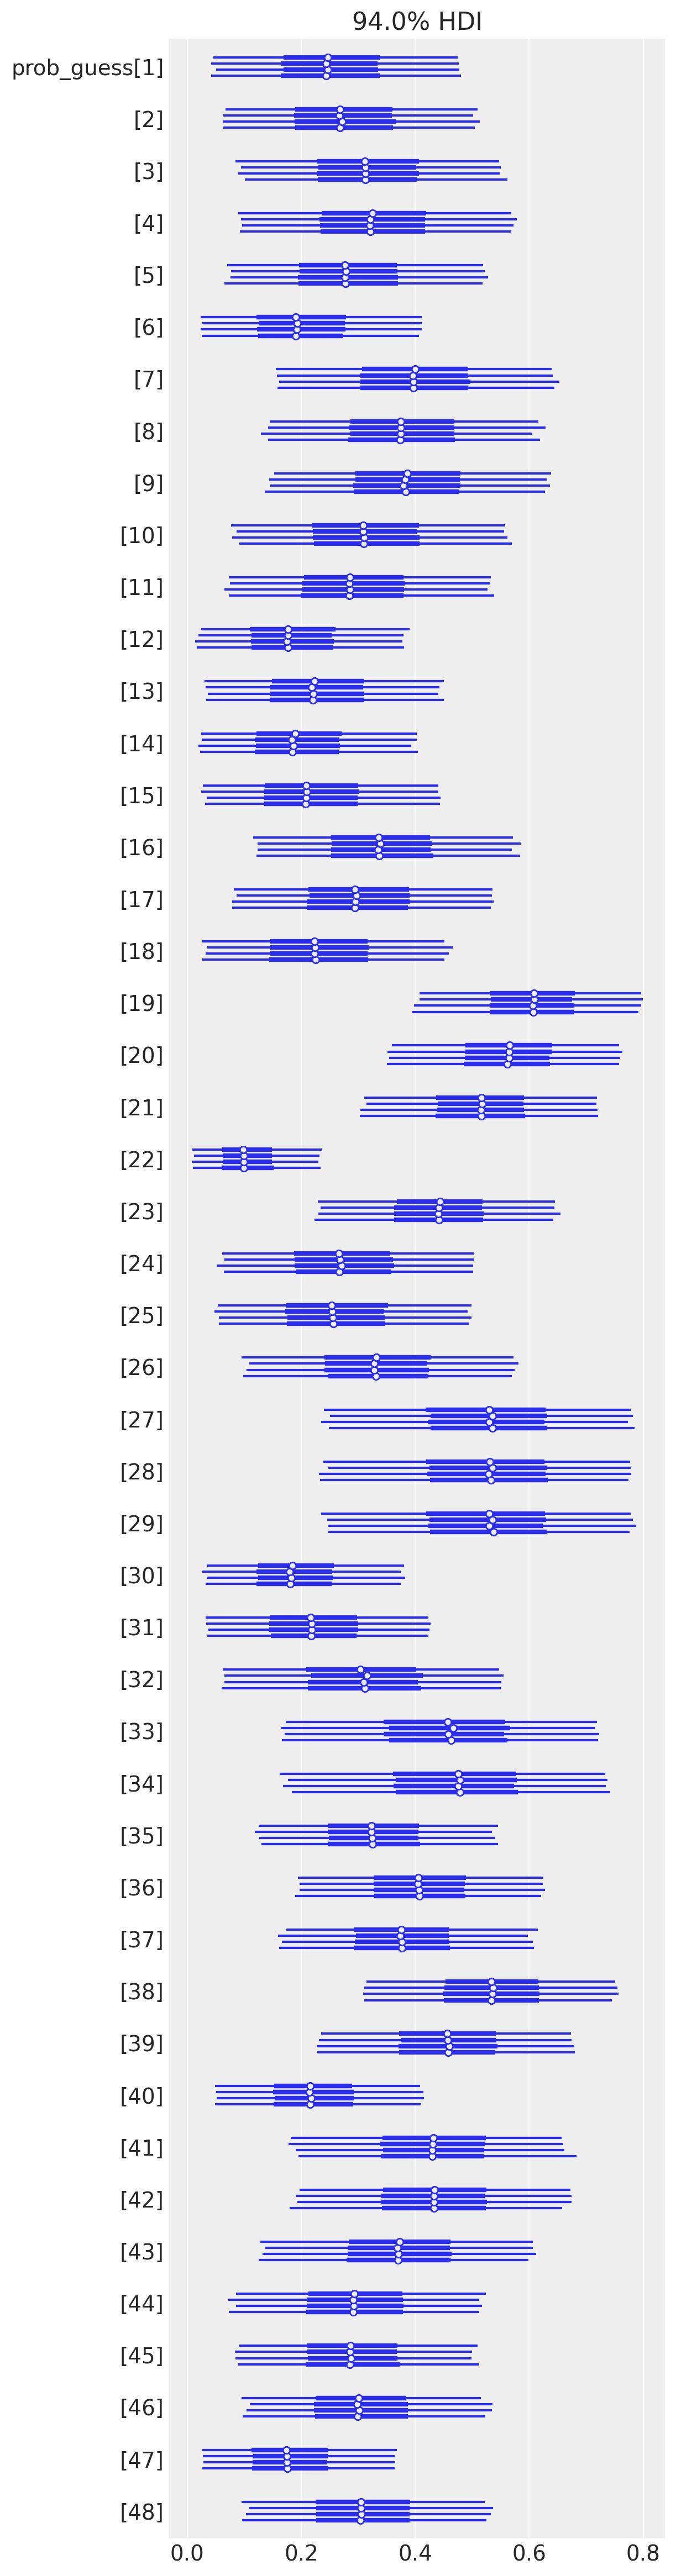

In [59]:
az.plot_forest(trace['posterior']['prob_guess'])

In [60]:
post_prob_skills = trace['posterior']['skills'].mean(axis=1).mean(axis=0).values
post_prob_skills.shape

(22, 7)

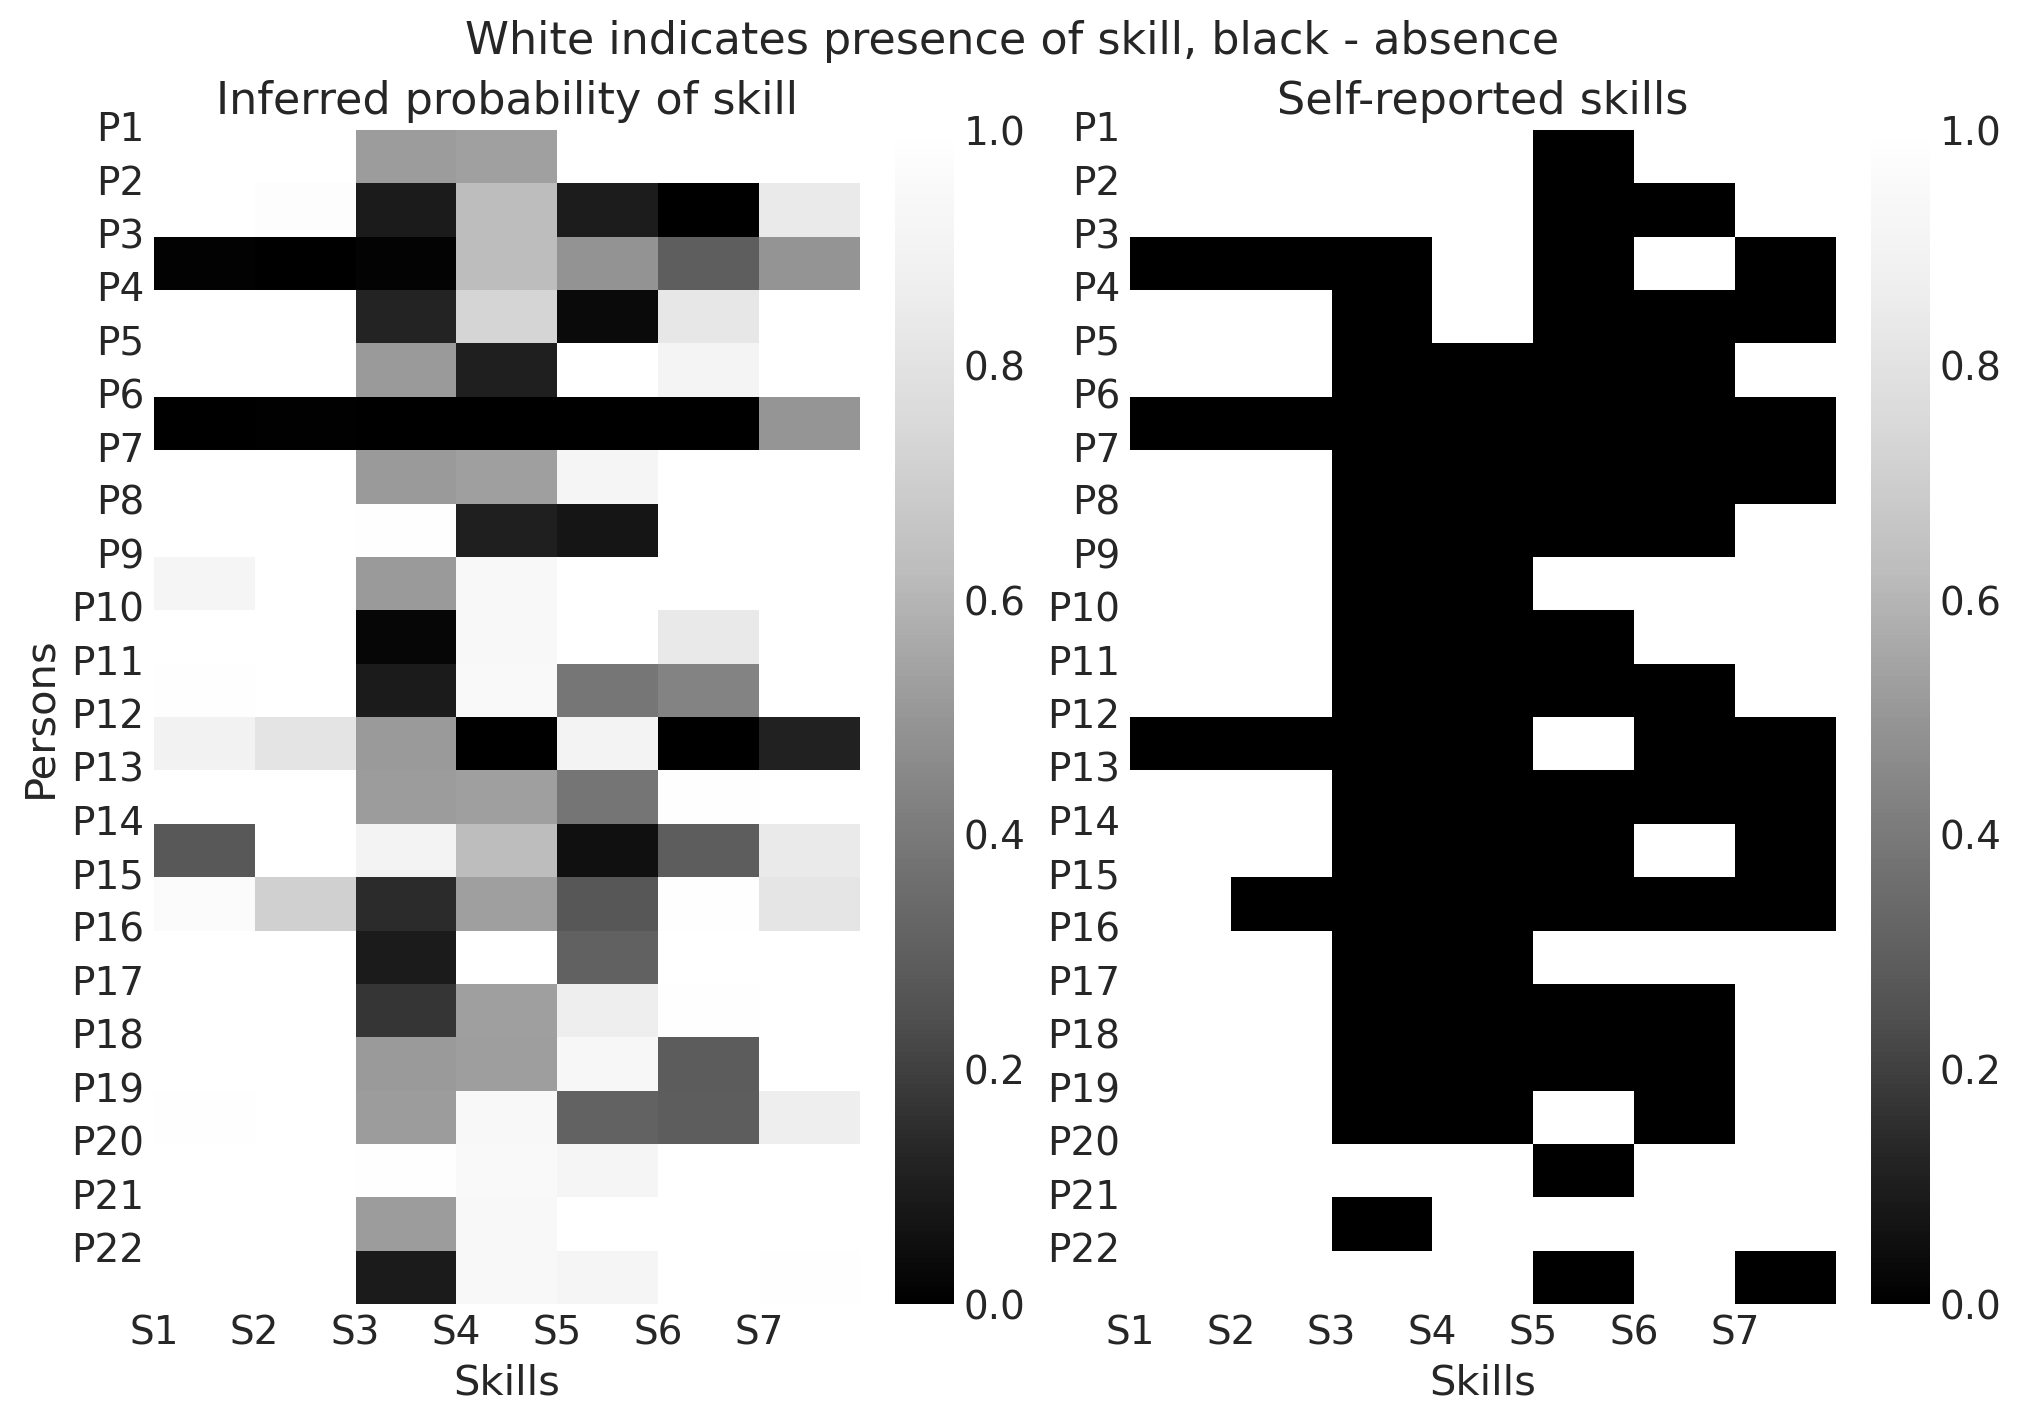

In [61]:
fig = plt.figure(figsize=(10, 7))
fig.suptitle('White indicates presence of skill, black - absence', fontsize=16)

xticks = HAS_SKILLS.columns
yticks = HAS_SKILLS.index


ax1 = fig.add_subplot(121)
sns.heatmap(post_prob_skills, color='white', ax=ax1, cmap=CMAP_BW)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('Persons')
_ = plt.xlabel('Skills')
_ = plt.title('Inferred probability of skill')


ax2 = fig.add_subplot(122)
sns.heatmap(HAS_SKILLS.astype(int), color='white', cmap=CMAP_BW, ax=ax2)
_ = plt.xticks(np.arange(len(xticks)), xticks, rotation=0)
_ = plt.yticks(np.arange(len(yticks)), yticks, rotation=0)
_ = plt.ylabel('')
_ = plt.xlabel('Skills')
_ = plt.title('Self-reported skills')